Systematics study of energy spectrum.
All required files are produced from "analysis_ML.ipynb"

In [1]:
'''
from sklearn.externals import joblib
import sklearn
from sklearn import metrics
import sklearn.ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV'''
import glob
import numpy
import sys, os
import tables
import pickle
from decimal import Decimal
from scipy.optimize import curve_fit
import pyunfold

#sys.path.append('/Users/ramesh/GoogleDrive/LowEnergy/Paper')
from weighting import H4a, GST, PolygonatoTG, GSF #H4a here is the proper H4a without adding proton only to H3a.
#sys.path.append('/Users/ramesh/GoogleDrive/python-tools/GSF')
sys.path.append('GSF')
import flux


In [2]:
import matplotlib
import matplotlib.backends.backend_pdf
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
%matplotlib inline

params = {'legend.fontsize': 16,
          'axes.labelsize': 20,
          'axes.titlesize':18,
          'xtick.labelsize':18,
          'ytick.labelsize':18,
          'figure.figsize':(8, 7),
          'axes.grid':True}
plt.rcParams.update(params)

In [3]:
print "Steering File"
print "Select what option to pass."

# Order what to do!!!!!
name               = '_paper' #'_13aug2018', '_23oct2018', '_10dec2018'
particle           = 'all'    # 'proton', 'helium', 'oxygen', 'iron', 'all'
composition_model  = 'h4a'    # 'h4a', 'gst', 'poly', 'gsfL', 'gsfM', 'gsfH'

which_systematics  = 'all' # composition, vemcal, pressure, all

# Values
cos1               = 1.00
cos2               = 0.90

# Link to a directory or a file
#savedir     = '/Users/rameshkoirala/Documents/Paper/'
rfr_savedir = '/Users/rameshkoirala/Documents/Paper/Plot/'


# Boolean
savefig            = False
savehdf            = False  # save important results, like flux, Aeff, resolution etc, in hdf files
do_h_fe            = False # Composition systematics using all H or all Fe H4a assumption.
isqgsjet           = True

pdgcode_dict       = {
                    'proton':2212,
                    'helium':1000020040,
                    'oxygen':1000080160,
                    'iron'  :1000260560
                     }

Steering File
Select what option to pass.


In [4]:
print "All required Functions"


# percentage increase is:
# x = logQtotal
#      at x=0, Qhillas > 50% of Qtotal
#      at x=1, Qhillas > 10% of Qtotal
#      at x=2, Qhillas > 5% of Qtotal
#      at x=3, Qhillas > 6% of Qtotal
def balloon_cut(x):
    return 0.2*x*x + 0.1*x - 0.3

def gaussian(x, a, b, c):
    # Gaussian function to be used for getting mean and sigma of energy distribution.                                               
    return a*numpy.exp(-(x-b)**2/(2*c*c))
    
def sigmoid_func(x, p0, p1, p2):
    return p0/(1 + numpy.exp(-p1*(x-p2))) # bhaktiyar sigmoid

def errorXbyY(X, Y, errX, errY):
    import numpy
    error = numpy.sqrt((errX/Y)**2 + (X*errY/(Y**2))**2)
    return error

def midBins(loge_bins, ind):
    # ind is integral_index i.e 1.65, differential index is 2.65
    lnE_bins = loge_bins/numpy.log10(numpy.exp(1))
    a        = lnE_bins[:-1]
    b        = lnE_bins[1:]
    mid = -1.*(numpy.log((numpy.exp(-ind*a) - numpy.exp(-ind*b))/(ind*(b-a)))/ind)
    return numpy.log10(numpy.exp(1))*mid

def systematics_quadrature(sys_list):
    total_systematics = 0
    for sys in sys_list:
        sys = numpy.array(sys)
        total_systematics += sys*sys
    return numpy.sqrt(total_systematics)

"""
Dynamic way of calculating Ngenerated.
Covers: what composition model?
        what particle type? [H only, He only, O only, Fe only or all of them at once.]

"""
def weighted_Ngenerated(loge_bins, 
                        particle='all', 
                        composition_model='h4a'):
    print ''
    print 'Ngenerated shower for a given zenith bin. Particle: ', particle

    # Calculate number of events generated that is used to do detector simulation.
    # This is required to calculate efficiency.
    import tables
    #sys.path.append('/Users/ramesh/GoogleDrive/LowEnergy/TankWiseLaputop')
    from weighting import weighting_H4a, weighting_GST, weighting_PolygonatoTG, weighting_GSF


    #mcdirpath = '/Users/ramesh/GoogleDrive/LowEnergy/RandomForest/MCPrimaryInfo/'
    mcdirpath = '/Users/rameshkoirala/Documents/LowEnergy/MCPrimaryInfo/'

    # Determines which function to use based on compositon model.
    weighting_func_dict = {
                            'h4a' : weighting_H4a,
                            'gst' : weighting_GST,
                            'poly': weighting_PolygonatoTG,
                            'gsfL': weighting_GSF,
                            'gsfL': weighting_GSF,
                            'gsfM': weighting_GSF,
                            'gsfH': weighting_GSF,
                          }
    # This is focused on Global Spline Fit which is divided into high, low and median.
    # For h4a, poly, and gst which_flux is there just to be consistent with GSF weighting function.
    which_flux_dict     = {
                            'h4a' : 'median',
                            'gst' : 'median',
                            'poly': 'median',
                            'gsfL': 'median',
                            'gsfL': 'low',
                            'gsfM': 'median',
                            'gsfH': 'high',
                          }

    weighting_func = weighting_func_dict[composition_model]
    which_flux     = which_flux_dict[composition_model]

    if particle=='all':
        particle_list = ['proton', 'helium', 'oxygen', 'iron']
        do            = 'one_particle_flux'
    else:
        particle_list = [particle]
        do            = 'all_particle_flux'

    wtNgen   = 0.
    Ngen_err = 0.
    num_evt  = 0.
    for par in particle_list:
        #print 'Particle: ', par
        filename = mcdirpath+'detector_sim_mcprimary_'+par+'.h5'
        hf       = tables.open_file(filename)
        energy   = hf.root.MCPrimary.cols.energy[:]
        if len(particle_list)==1: # one particle assumption
            node_name = 'weight_1ParAssumption_'+par+'_'+composition_model+'Orig'
        if len(particle_list)==4: # 4 groups of particle.
            node_name = 'weight_'+par+'_'+composition_model+'Orig'
        if node_name in hf.root:
            wt_n      = hf.get_node('/', node_name)
            wt        = wt_n.read()
        else:
            hf.close()
            wt        = weighting_func(energy, particle=par, do=do, which_flux=which_flux)
            hf        = tables.open_file(filename, 'a')
            hf.create_array('/', node_name, wt)
                
        czenith   = numpy.cos(hf.root.MCPrimary.cols.zenith[:])
        mask      = (czenith>=cos2)*(czenith<=cos1)
        hf.close()
        Ngen_     = numpy.histogram(energy[mask], bins=10**loge_bins)[0]
        wtNgen_   = numpy.histogram(energy[mask], bins=10**loge_bins, weights=wt[mask])[0]
        Ngen_err_ = numpy.histogram(energy[mask], bins=10**loge_bins, weights=(wt[mask])*(wt[mask]))[0]
        wtNgen   += wtNgen_
        Ngen_err += Ngen_err_ 
        num_evt  += Ngen_
        Ngen_err[numpy.where(numpy.isinf(Ngen_err))] = 0
        
    return wtNgen, Ngen_err, num_evt

def weight_1particle(energy,
                     loge_bins=numpy.linspace(4.0,7.6,19),
                     particle='proton',
                     composition_model='h4a'):
    print ''
    print 'Ngenerated shower for a given zenith bin. Particle: ', particle

    # Calculate number of events generated that is used to do detector simulation.
    # This is required to calculate efficiency.
    import tables
    sys.path.append('/Users/ramesh/GoogleDrive/LowEnergy/TankWiseLaputop/')
    from weighting import weighting_H4a, weighting_GST, weighting_PolygonatoTG, weighting_GSF


    mcdirpath = '/Users/ramesh/GoogleDrive/LowEnergy/RandomForest/MCPrimaryInfo/'
    

    # Determines which function to use based on compositon model.
    weighting_func_dict = {
                            'h4a' : weighting_H4a,
                            'gst' : weighting_GST,
                            'poly': weighting_PolygonatoTG,
                            'gsfL': weighting_GSF,
                            'gsfL': weighting_GSF,
                            'gsfM': weighting_GSF,
                            'gsfH': weighting_GSF,
                          }
    # This is focused on Global Spline Fit which is divided into high, low and median.
    # For h4a, poly, and gst which_flux is there just to be consistent with GSF weighting function.
    which_flux_dict     = {
                            'h4a' : 'median',
                            'gst' : 'median',
                            'poly': 'median',
                            'gsfL': 'median',
                            'gsfL': 'low',
                            'gsfM': 'median',
                            'gsfH': 'high',
                          }

    weighting_func = weighting_func_dict[composition_model]
    which_flux     = which_flux_dict[composition_model]

    if particle=='all':
        raise Exception('You can only calcuate weight for 1 particle assumption using this function')
    else:
        do = 'all_particle_flux'

    wt     = weighting_func(energy, particle=particle, do=do, which_flux=which_flux)
        
    return wt

def efficiency(logEnergy, Weight, 
               loge_bins, 
               particle='all', 
               composition_model='h4a'):
    """
    Efficiency for input logenergy after all quality cuts. Energy can be both True or Reconstructed.
    """
    wtNgenerated, Ngen_err, num_evt_gen = weighted_Ngenerated(loge_bins, particle=particle, composition_model=composition_model)
    wtNtrue   = numpy.histogram(logEnergy, bins=loge_bins, weights=Weight)[0]
    Ntrue_err = numpy.sqrt(numpy.histogram(logEnergy, bins=loge_bins, 
                                           weights=(Weight*Weight))[0])
    print len(Ntrue_err),len(wtNgenerated)
    error_eff = numpy.sqrt((Ntrue_err/wtNgenerated)**2 + (wtNtrue*Ngen_err/(wtNgenerated**2))**2)
    eff       = wtNtrue/wtNgenerated
    
    return eff, error_eff

def effective_area(eff, loge_bins, fitted=False):
    # This works both for effective area and its error.
    # Input: Efficiency, or Error on efficiency.
    
    truncated_bins = loge_bins[:-1] 
    if isinstance(eff, (numpy.ndarray, list)):
        pass
    elif isinstance(eff, (float, int)):
        eff = numpy.ones(len(truncated_bins)) * eff 

    RSim45 = 200.
    RSim56 = 400.
    RSim67 = 600.
    RSim78 = 800.

    AreaSim45 = numpy.pi*RSim45*RSim45
    AreaSim56 = numpy.pi*RSim56*RSim56
    AreaSim67 = numpy.pi*RSim67*RSim67
    AreaSim78 = numpy.pi*RSim78*RSim78

    mask45 = (truncated_bins>=4)*(truncated_bins<5)
    mask56 = (truncated_bins>=5)*(truncated_bins<6)
    mask67 = (truncated_bins>=6)*(truncated_bins<7)
    mask78 = (truncated_bins>=7)*(truncated_bins<8)

    Aeff         = numpy.zeros(len(eff))
    Aeff[mask45] = AreaSim45*(eff[mask45])
    Aeff[mask56] = AreaSim56*(eff[mask56])
    Aeff[mask67] = AreaSim67*(eff[mask67])
    Aeff[mask78] = AreaSim78*(eff[mask78])
    
    if fitted:
        mid_logE = 0.5*(loge_bins[1:]+loge_bins[:-1])
        effx = numpy.linspace(min(mid_logE),max(mid_logE),501)
        init = [max(Aeff)/2., 5., 5.]
        mask = (mid_logE>=5.4)*(mid_logE<=7.0)
        popt, pcov = curve_fit(sigmoid_func, mid_logE[mask], Aeff[mask], 
                                 p0=init, sigma=ErrAeff[mask])
        Aeff               = sigmoid_func(mid_logE, *popt)
        return Aeff, popt, pcov

    else:
        return Aeff

def cr_flux(logene_spectrum, 
        loge_bins=numpy.linspace(4,7.4,18), 
        Aeff=1.,
        cos1=1, cos2=0.9,
        duration=1.
        ):
    lnE      = loge_bins/numpy.log10(numpy.exp(1))
    dlnE     = numpy.diff(lnE)
    exposure = Aeff*numpy.pi*((cos1**2) - (cos2**2))*duration
    flux     = logene_spectrum/(dlnE*exposure)
    
    return flux
    
def predict_energy(column_stack, composition_model='', particle='all', isqgsjet=False):
    
    print 'Predicting energy for model: %s'%composition_model
    n = 20
    
    numpy.random.shuffle(column_stack)
    label     = column_stack[:,0]
    features  = column_stack[:,1:-7]
    print 'features.shape:', features.shape
    features  = features.astype(numpy.float32)
    features  = numpy.nan_to_num(features)

    # Use saved model
    rfr_model_filename = rfr_savedir+'rfr_finalized_model_all_'+composition_model+'.sav'
    test_samples_file  = rfr_savedir+'test_samples_all_'+composition_model+'.sav'
    models       = pickle.load(open(rfr_model_filename, 'rb'))
    tsfile       = open(test_samples_file,'rb')
    test_samples = pickle.load(tsfile)
    tsfile.close()
    
    if (particle!='all') or isqgsjet:
        avg_predicted = 0.
        for i, test in enumerate(test_samples):
            print "================================="
            print "using model with index ", i, particle
            avg_predicted += models[i].predict(features)
            
        penergy = avg_predicted/(1.*len(models))
        
    else:
        predicted = numpy.array([])
        for i, test in enumerate(test_samples):
            print "================================="
            print "using model with index ", i
            print 'Test Index: ', test
            prediction = models[i].predict(features[test])
            predicted = numpy.append(predicted, prediction)
            print "append prediction of shape", prediction.shape, "to array"
        
        penergy = predicted
            
    tenergy = label
    print "================================="
    return column_stack, penergy, tenergy
    
def column_stack_block(particle, isqgsjet=False):
    # DO NOT use 'column_stack' as function name because it matches with 'numpy.colum_stack'.
    import tables, numpy
    
    n = 20
    datadir = '/Users/ramesh/GoogleDrive/LowEnergy/'
    if isqgsjet:
        #hfreadfile = datadir+'analysis_simulation_sta2_Ntanks_leq35_ML_qgsjet_'+particle+'.h5'
        hfreadfile = datadir+'analysis_simulation_HLCCoreSeed_qgsjet_all.h5'
    else:
        hfreadfile = datadir+'analysis_simulation_sta2_Ntanks_leq35_'+particle+'.h5'
        
    print 'Reading data from: ', hfreadfile
    hf = tables.open_file(hfreadfile)
    Tenergy    = hf.root.Energy[:]
    FiltCondt  = hf.root.FiltCondt[:]
    LoudSta    = hf.root.LoudSta[:]
    Qhillas   = hf.root.Qhillas[:]
    Qtotal    = hf.root.Qtotal[:]
    Qmax      = hf.root.Qmax[:]
    Qtotalhlc = hf.root.Qtotalhlc[:]
    Nsta      = hf.root.Nsta[:]
    Nslc      = hf.root.Nslc[:]
    Ntanks    = hf.root.Ntanks[:]
    #PredictedX= hf.root.PredictedX[:]
    #PredictedY= hf.root.PredictedY[:]
    PredictedX= hf.root.COGX[:]
    PredictedY= hf.root.COGY[:]
    Tzenith    = hf.root.Tzenith[:]
    Rzenith    = hf.root.Plane_Zenith[:]
    Pzenith    = Rzenith
    Pulses     = numpy.array(hf.root.Pulses[:])
    TankX      = numpy.array(hf.root.TankX[:])
    TankY      = numpy.array(hf.root.TankY[:])
    Weightpoly = hf.root.WeightPoly[:]
    Weighth4a  = hf.root.WeightH4a[:]
    Weightgst  = hf.root.WeightGST[:]
    WeightgsfL = hf.root.WeightGSFL[:]
    WeightgsfM = hf.root.WeightGSFM[:]
    WeightgsfH = hf.root.WeightGSFH[:]
    PDG        = hf.root.pdg_encoding[:]
    hf.close()
    
    #----------------------------
    # Calculated 
    Qsum2      = numpy.sum(Pulses[:, :2], axis=1) # sum of two highest Pulses.
    Radius     = numpy.sqrt((TankX - PredictedX[:,numpy.newaxis])**2 + (TankY - PredictedY[:,numpy.newaxis])**2)
    Radius[numpy.where((TankX==0)*(TankY==0))] = 0. #If nothing was hit, tank positions was set to (0,0) to fill array. 
    Radius     = -numpy.sort(-Radius, axis=1) # Distance of tank-core in descending order per event.
    fracRadius = Radius/Rref
    maxRadius  = numpy.max(Radius, axis=1)
    TankDensity= Ntanks/(numpy.pi*maxRadius*maxRadius)

    # Quality Cuts
    qualmask = FiltCondt==1
    qualmask *= (LoudSta==1)
    qualmask *= (numpy.log10(Qhillas)>=balloon_cut(numpy.log10(Qtotal)))
    qualmask *= (Qsum2<=qsum2_frac*Qtotal) # Make sure not all charge is stored in 1 station.
    qualmask *= (numpy.cos(Pzenith)>=0.8)*(numpy.cos(Pzenith)<=1.0)
    qualmask *= (Nsta<=50)*(Nslc<=40)*(Ntanks<=112)*(Qtotal<=1.e4)
    qualmask *= (TankDensity<=tankdenvalue)

    # Apply mask on arrays before training
    Tenergy   = Tenergy[qualmask]
    Qhillas   = Qhillas[qualmask]
    Qtotal    = Qtotal[qualmask]
    Ntanks    = Ntanks[qualmask]
    Pzenith   = Pzenith[qualmask]
    Nslc      = Nslc[qualmask]
    Qtotalhlc = Qtotalhlc[qualmask]
    Pulses    = Pulses[qualmask]
    fracRadius= fracRadius[qualmask]
    Weightpoly = Weightpoly[qualmask]
    Weighth4a  = Weighth4a[qualmask]
    Weightgst  = Weightgst[qualmask]
    WeightgsfL = WeightgsfL[qualmask]
    WeightgsfM = WeightgsfM[qualmask]
    WeightgsfH = WeightgsfH[qualmask]
    PDG        = PDG[qualmask]
    
    col_stack = numpy.column_stack((numpy.log10(Tenergy),
                                    numpy.log10(Qhillas), 
                                    numpy.log10(Qtotal),
                                    numpy.log10(Ntanks),
                                    numpy.cos(Pzenith),
                                    Nslc,
                                    numpy.log10(Qtotalhlc),
                                    numpy.log10(Pulses[:,:n]),
                                    numpy.log10(fracRadius[:,:n]),
                                    PDG,
                                    Weightpoly,
                                    Weighth4a,
                                    Weightgst,
                                    WeightgsfL,
                                    WeightgsfM,
                                    WeightgsfH
                                   ))
    return col_stack

All required Functions


In [5]:
print 'All required Bins'
loge_bins     = numpy.linspace(4.0,7.4,18)    # 18, 35

# ======== mid_logE = mean(Etrue) for loge_bins ==========
if len(loge_bins)==18:    
    if isqgsjet:
        mid_logE = numpy.array([4.0999999999999996, 4.3268018860995792, 4.5134649169947147, 4.7042433513022983, 
                                4.9066543785895229, 5.1121041833890448, 5.3068843245834696, 5.4973719248539155, 
                                5.703174513944453, 5.8889102043640618, 6.0921336536050017, 6.292517305885835, 
                                6.4900351375626437, 6.6843553462208334, 6.8872274958248525, 7.090983456078563, 
                                7.2830830926138885])
    else:
        mid_logE     = numpy.array([4.12821881,  4.31611802,  4.51082764,  4.70709536,  4.90634721,
                                5.1027005 ,  5.29863315,  5.49811971,  5.69467844,  5.89531019,
                                6.09042669,  6.29077748,  6.49052739,  6.68873398,  6.88745929,
                                7.08888133,  7.28533777])
if len(loge_bins)==35:
    mid_logE  = numpy.array([4.06866143,  4.15494338,  4.25434482,  4.35423006,  4.45353304,  
                             4.55177466,  4.65120517,  4.75186103,  4.85092255,  4.95213942,  
                             5.05120567,  5.1489875 ,  5.25003544,  5.34942088,  5.45018824,
                             5.54913825,  5.64949103,  5.74873638,  5.84865991,  5.94939676,
                             6.04705505,  6.14854764,  6.24680755,  6.34714717,  6.44805671,
                             6.54699769,  6.64834655,  6.74572035,  6.84455305,  6.94872205,
                             7.0471024 ,  7.14747452,  7.2456188,   7.34451519])

ene_mask      = (mid_logE>=5.4)*(mid_logE<=7.0)

All required Bins


In [6]:
print name

_paper


In [7]:
# Select events within cos1 and cos2.

if isqgsjet:
    datadir = "/Users/rameshkoirala/Documents/Paper/"
    name            += 'QGSJET'
    datafile         = "analysis_simulation_HLCCoreSeed_slcQcut_everything_qgsjet_final.h5"
    responseMname    = 'response_matrix%s.h5'%name
else:
    #datadir = "/Users/ramesh/GoogleDrive/LowEnergy/Paper/"
    datadir          = '/Users/rameshkoirala/Documents/Paper/'
    datafile         = "analysis_simulation_HLCCoreSeed_slcQcut_fracradius_final.h5"
    responseMname    = 'response_matrix_sybill%s.h5'%name

hf         = tables.open_file(datadir+datafile)
logTenergy = numpy.log10(hf.root.Energy[:])
if isqgsjet:
    logPenergy = hf.root.PredictedLogEnergy_h4aOrig_QGSJET[:]
    maskene   = hf.root.maskTrainingEnergy_h4aOrig_QGSJET[:]
else:
    logPenergy = hf.root.PredictedLogEnergy_h4aOrig[:]
    maskene   = hf.root.maskTrainingEnergy_h4aOrig[:]
Nsta      = hf.root.Nsta[:]
Qtotalhlc = hf.root.Qtotalhlc[:]
Pulses    = hf.root.Pulses[:]
Qmax      = Pulses[:,0]
Qsum2     = numpy.sum(Pulses[:,:2], axis=1)
Pzenith   = hf.root.PredictedZen[:]
WeightH4a = hf.root.WeightH4aOrig[:]
WeightGST = hf.root.WeightGST[:]
WeightPoly= hf.root.WeightPoly[:]
WeightGSFL= hf.root.WeightGSFL[:]
WeightGSFM= hf.root.WeightGSFM[:]
WeightGSFH= hf.root.WeightGSFH[:]
PDG       = hf.root.pdg_encoding[:]
hf.close()

logTenergy= logTenergy[maskene]
Qtotalhlc = Qtotalhlc[maskene]
Qmax      = Qmax[maskene]
Qsum2     = Qsum2[maskene]
Nsta      = Nsta[maskene]
Pzenith   = Pzenith[maskene]
PDG       = PDG[maskene]
WeightH4a = WeightH4a[maskene]
WeightGST = WeightGST[maskene]
WeightPoly= WeightPoly[maskene]
WeightGSFL= WeightGSFL[maskene]
WeightGSFM= WeightGSFM[maskene]
WeightGSFH= WeightGSFH[maskene]

# Now apply additional quality cuts
qualmask  = (numpy.cos(Pzenith)>=0.9)*(numpy.cos(Pzenith)<=1.0)
qualmask *= (Nsta<=42)*(Qtotalhlc<=10**3.8)*(Qtotalhlc>=10**-0.2)
qualmask *= Qmax<=0.75*Qtotalhlc
qualmask *= Qsum2<=0.9*Qtotalhlc

# Apply mask to make it ready to calculate resolution.
tenergy    = logTenergy[qualmask]
penergy    = logPenergy[qualmask]
pdg        = PDG[qualmask]
weighth4a  = WeightH4a[qualmask]
weightgst  = WeightGST[qualmask]
weightgsfL = WeightGSFL[qualmask]
weightgsfM = WeightGSFM[qualmask]
weightgsfH = WeightGSFH[qualmask]
weightpoly = WeightPoly[qualmask]

# H4a, all Proton assumption
pdgcodeH = pdgcode_dict['proton']
maskH    = (pdg==pdgcodeH)
penergyH = penergy[maskH]
tenergyH = tenergy[maskH]

weighth4aH = weight_1particle(10**tenergyH,
                     particle='proton',
                     composition_model=composition_model)

# H4a, all Iron assumption
pdgcodeFe = pdgcode_dict['iron']
maskFe    = (pdg==pdgcodeFe)
penergyFe = penergy[maskFe]
tenergyFe = tenergy[maskFe]

weighth4aFe = weight_1particle(10**tenergyFe,
                     particle='iron',
                     composition_model=composition_model)

print 'Done'


Ngenerated shower for a given zenith bin. Particle:  proton

Ngenerated shower for a given zenith bin. Particle:  iron
Done


In [8]:
print name

_paperQGSJET


In [9]:
# --------------------------------------------------------------
print responseMname
hf               = tables.open_file(responseMname)
response         = hf.root.response[:]
response_err     = hf.root.response_err[:]
efficiencies     = hf.root.efficiencies[:]
efficiencies_err = hf.root.efficiencies_err[:]
hf.close()

# --------------------------------------------------------------
print 'unfolding_flux_result%s.h5'%name
hf          = tables.open_file(rfr_savedir+'unfolding_flux_result%s.h5'%name)
Aeff        = hf.get_node('/', 'Aeff_len%i'%len(mid_logE))[:]
ErrAeff     = hf.get_node('/', 'ErrAeff_len%i'%len(mid_logE))[:]
hf.close()

# --------------------------------------------------------------
if isqgsjet:
    spline_fit_mask   = 1*(mid_logE>=4.6) #fit values within 5.4 to 7.0 and rest seperately.
    degree            = 2 # this is just a regularizer. Get rid of first 3 empty bins for Iron assumption.
else:
    spline_fit_mask   = 1*(mid_logE>=4.0) # Do nothing. Use all bins.
    degree            = 3
    
logger       = pyunfold.Logger()
regularizer  = pyunfold.callbacks.PolynomialRegularizer(degree=degree, groups=spline_fit_mask)
prior        = pyunfold.priors.jeffreys_prior(mid_logE) #uniform_prior, jeffreys_prior    
ts           ='ks'          # ‘ks’, ‘chi2’, ‘bf’, ‘rmd’}
ts_stopping  = 1e-3
max_iter     = 50
cov_type     = 'multinomial'
return_iterations=False      #Whether to return unfolded distributions for each iteration
callbacks    = [logger, regularizer]

def flux_error(penergy_y, error_eney):
    unfolded_result = pyunfold.iterative_unfold(data=penergy_y,
                                       data_err=numpy.nan_to_num(error_eney),
                                       response=response,
                                       response_err=response_err,
                                       efficiencies=efficiencies,
                                       efficiencies_err=efficiencies_err,
                                       prior=prior,
                                       ts=ts, ts_stopping=ts_stopping,
                                       callbacks=callbacks,
                                       max_iter=max_iter,
                                       return_iterations=return_iterations
                                      )

    unfolded= unfolded_result['unfolded']
    stat_err= unfolded_result['stat_err']
    flux       = cr_flux(unfolded,
                      loge_bins=loge_bins,
                      Aeff=Aeff,
                      cos1=cos1, cos2=cos2
                     )
    stat_error = cr_flux(stat_err,
                      loge_bins=loge_bins,
                      Aeff=Aeff,
                      cos1=cos1, cos2=cos2
                     )

    return flux, stat_error

response_matrix_paperQGSJET.h5
unfolding_flux_result_paperQGSJET.h5


In [10]:
scale     = 1.

plt.rcParams.update({'figure.figsize':(10, 7)})

if which_systematics=='composition' or which_systematics=='all':
    # =======================================================
    print 'Unfolded Energy spectrum for GSF_M'
    ygsfM, x   = numpy.histogram(penergy, 
                                   bins=loge_bins, 
                                   weights=weightgsfM)
    errorgsfM = numpy.sqrt(numpy.histogram(penergy, 
                            bins=loge_bins, 
                            weights=((weightgsfM*weightgsfM)))[0])
    fluxgsfM, error_fluxgsfM  = flux_error(ygsfM, errorgsfM)

    # ===========================================================
    print 'Unfolded Energy Histogram PolygonatoTG'
    ypoly, x   = numpy.histogram(penergy, 
                                   bins=loge_bins, 
                                   weights=weightpoly)
    errorypoly = numpy.sqrt(numpy.histogram(penergy, 
                            bins=loge_bins, 
                            weights=((weightpoly*weightpoly)))[0])
    fluxpoly, error_fluxpoly  = flux_error(ypoly, errorypoly)
    
    # ==========================================================
    # ==========================================================
    print 'Unfolded Energy Histogram H4a'
    yh4a, x   = numpy.histogram(penergy, 
                                bins=loge_bins, 
                                weights=weighth4a)
    erroryh4a = numpy.sqrt(numpy.histogram(penergy, 
                            bins=loge_bins, 
                            weights=((weighth4a*weighth4a)))[0])
    fluxh4a, error_fluxh4a  = flux_error(yh4a, erroryh4a)

    # =============================================================
    # =============================================================
    print 'Unfolded Energy Histogram GST'
    ygst, x   = numpy.histogram(penergy, 
                                   bins=loge_bins, 
                                   weights=weightgst)    
    errorygst = numpy.sqrt(numpy.histogram(penergy, 
                            bins=loge_bins, 
                            weights=((weightgst*weightgst)))[0])
    fluxgst, error_fluxgst  = flux_error(ygst, errorygst)

print 'Done'

Unfolded Energy spectrum for GSF_M
Iteration 1: ts = 0.4005, ts_stopping = 0.001
Iteration 2: ts = 0.0457, ts_stopping = 0.001
Iteration 3: ts = 0.0065, ts_stopping = 0.001
Iteration 4: ts = 0.0013, ts_stopping = 0.001
Iteration 5: ts = 0.0003, ts_stopping = 0.001
Unfolded Energy Histogram PolygonatoTG
Iteration 1: ts = 0.3909, ts_stopping = 0.001
Iteration 2: ts = 0.0456, ts_stopping = 0.001
Iteration 3: ts = 0.0062, ts_stopping = 0.001
Iteration 4: ts = 0.0011, ts_stopping = 0.001
Iteration 5: ts = 0.0002, ts_stopping = 0.001
Unfolded Energy Histogram H4a
Iteration 1: ts = 0.3970, ts_stopping = 0.001
Iteration 2: ts = 0.0456, ts_stopping = 0.001
Iteration 3: ts = 0.0064, ts_stopping = 0.001
Iteration 4: ts = 0.0012, ts_stopping = 0.001
Iteration 5: ts = 0.0003, ts_stopping = 0.001
Unfolded Energy Histogram GST
Iteration 1: ts = 0.3944, ts_stopping = 0.001
Iteration 2: ts = 0.0459, ts_stopping = 0.001
Iteration 3: ts = 0.0062, ts_stopping = 0.001


/Users/rameshkoirala/anaconda2/lib/python2.7/site-packages/pyunfold/callbacks.py:198: RuntimeWarning: divide by zero encountered in log10
  poly_fitted = np.poly1d(np.polyfit(x_group, np.log10(y_group), self.degree))


Iteration 4: ts = 0.0012, ts_stopping = 0.001
Iteration 5: ts = 0.0003, ts_stopping = 0.001
Done


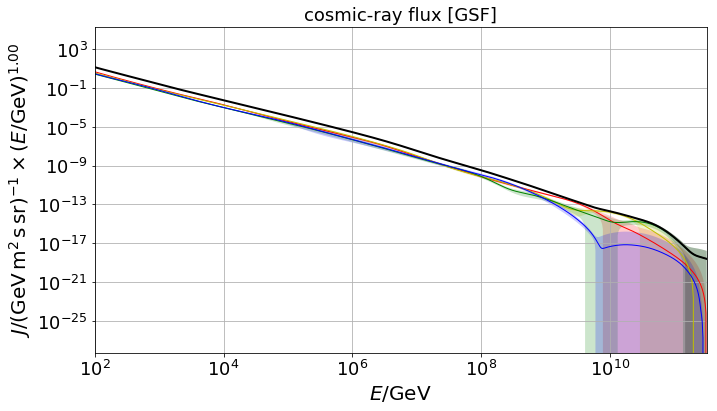

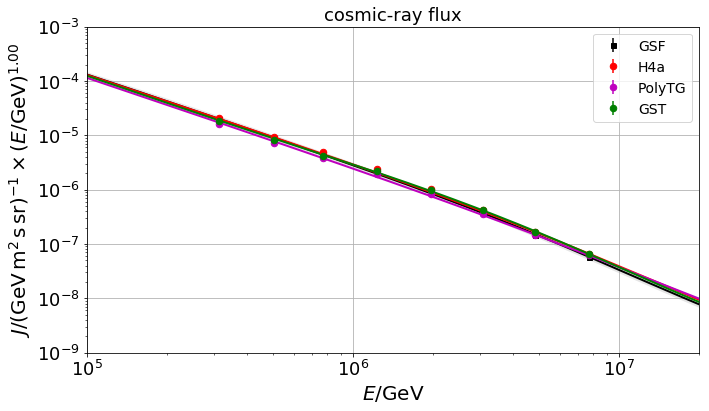

In [11]:
# Credit: Work related GSF model is done by Hans Dembinski including plotting scripts.
if which_systematics=='composition' or which_systematics=='all':
    scale = 1.

    energy_exponent = 1.
    ene_mask = (mid_logE>=5.4)*(mid_logE<=7)

    x = 10 ** numpy.linspace(0, 11.5, 1000)
    y1 = flux.group_flux(1, x)
    y2 = flux.group_flux(2, x)
    y3 = flux.group_flux(8, x)
    y4 = flux.group_flux(26, x)
    y5 = y1 + y2 + y3 + y4

    y1err = numpy.diag(flux.group_flux_cov(1, 1, x)) ** 0.5
    y2err = numpy.diag(flux.group_flux_cov(2, 2, x)) ** 0.5
    y3err = numpy.diag(flux.group_flux_cov(8, 8, x)) ** 0.5
    y4err = numpy.diag(flux.group_flux_cov(26, 26, x)) ** 0.5
    y5cov = 0.0
    for l1 in (1, 2, 8, 26):
        for l2 in (1, 2, 8, 26):
            y5cov += flux.group_flux_cov(l1, l2, x)
    y5err = numpy.diag(y5cov) ** 0.5

    plt.figure(figsize=(10, 6))
    plt.subplots_adjust(left=0.12, right=0.97)
    for y, yerr, col in ((y1, y1err, "r"), (y2, y2err, "y"), (y3, y3err, "g"),
                         (y4, y4err, "b"), (y5, y5err, "k")):
        plt.plot(x, y * x ** energy_exponent, "-", color=col, lw=2 if col=="k" else 1)
        plt.fill_between(x, (y - yerr) * x ** energy_exponent,
                         (y + yerr) * x ** energy_exponent,
                         facecolor=col, alpha=0.2)
    #plt.hlines(15e3, 1e2, 1e11)
    plt.loglog(nonposy="clip")
    plt.xlabel("$E$/GeV")
    plt.ylabel(r"$J/(\mathrm{GeV\,m^2\,s\,sr})^{-1} \times (E/\mathrm{GeV})^{%.2f}$"%scale)
    plt.xlim(1e2, 10 ** 11.5)
    #plt.ylim(1e1, 4e4)
    plt.title("cosmic-ray flux [GSF]")
    if savefig:
        #plt.savefig('/Users/ramesh/GoogleDrive/LowEnergy/Plot/CR_flux_spectrum_logntanks_background_h4a_scaled_v1.png')
        plt.savefig(rfr_savedir+'GSF_composition_model.png')


    # =========================================================================================
    model_scaling_factor = x**(scale-1)
    model_h4a  = model_scaling_factor*H4a(particle='all', E=x)
    model_gst  = model_scaling_factor*GST(particle='all', E=x)
    model_poly = model_scaling_factor*PolygonatoTG(particle='all', E=x)

    plt.figure(figsize=(10, 6))
    plt.subplots_adjust(left=0.12, right=0.97)
    # GSF --------
    plt.plot(x, y5 * x ** energy_exponent, "-", color="k", lw=2)
    plt.fill_between(x, (y5 - y5err) * x ** energy_exponent,
                     (y5 + y5err) * x ** energy_exponent,
                     facecolor=col, alpha=0.1)
    plt.errorbar(10**mid_logE[ene_mask], fluxgsfM[ene_mask], yerr=error_fluxgsfM[ene_mask], markersize=5,
                     color='k', fmt=' ', marker='s', label='GSF')

    # H4a --------
    plt.errorbar(10**mid_logE[ene_mask], fluxh4a[ene_mask], 
                 yerr=error_fluxh4a[ene_mask], 
                 markersize=6.5, color='r', fmt=' ', marker='o', label='H4a')
    plt.plot(x, model_h4a, 'r', lw=2)

    if do_h_fe:
        plt.errorbar(10**mid_logE[ene_mask], fluxh4aH[ene_mask], 
                     yerr=error_fluxh4aFe[ene_mask], 
                     markersize=6.5, color='r', fmt=' ', marker='o', label='MC [H4a, H]', alpha=0.6)

        plt.errorbar(10**mid_logE[ene_mask], fluxh4aFe[ene_mask], 
                     yerr=error_fluxh4aFe[ene_mask], 
                     markersize=6.5, color='r', fmt=' ', marker='o', label='MC [H4a, Fe]', alpha=0.4)
    
    # PolygonatoTG ----------
    plt.errorbar(10**mid_logE[ene_mask], fluxpoly[ene_mask], 
                 yerr=error_fluxpoly[ene_mask], 
                 markersize=6.5, color='m', fmt=' ', marker='o', label='PolyTG')
    plt.plot(x, model_poly, 'm', lw=2)

    # GST -----------
    plt.errorbar(10**mid_logE[ene_mask], fluxgst[ene_mask], 
                 yerr=error_fluxgst[ene_mask], 
                 markersize=6.5, color='g', fmt=' ', marker='o', label='GST')
    plt.plot(x, model_gst, 'g', lw=2)
    
    #plt.hlines(15e3, 1e2, 1e11)
    plt.loglog(nonposy="clip")
    plt.xlabel("$E$/GeV")
    plt.ylabel(r"$J/(\mathrm{GeV\,m^2\,s\,sr})^{-1} \times (E/\mathrm{GeV})^{%.2f}$"%scale)
    plt.xlim(1e5, 2e7)
    plt.ylim(1e-9, 1e-3)
    plt.title("cosmic-ray flux")
    plt.legend(loc='best', fontsize=14, frameon=True)
    if savefig and do_h_fe:
        plt.savefig(rfr_savedir+'composition_systematics_various_models_HFe_H4a'+name+'.png')
    elif savefig and not do_h_fe:
        plt.savefig(rfr_savedir+'composition_systematics_various_models'+name+'.png')


In [12]:
# Systematics for composition is the difference between the given composition model and its MC flux using Response
#   matrix generated by GSF composition Model.
# Several composition model is tried. Half of maximum difference is used as the composition systematics.

# This is also used for Hadronic interaction model systematics. So it is outside the 
#  'if' condition.
if len(mid_logE)==17:
    sys_y = numpy.arange(0,11.5,step=0.2)+0.1
elif len(mid_logE)==34:
    sys_y = numpy.arange(0,11.5,step=0.1)+0.05
sys_x = 10**sys_y

sys_bhak_bin = numpy.arange(4.0,7.4,0.2)+0.1
sys_bhak_mask= (sys_bhak_bin>=5.4)*(sys_bhak_bin<=7.0)

# Create mask to have energy bins equal to mid_logE
sys_ymask = (sys_y>=4.0)*(sys_y<=7.4)

model_scaling_factor = sys_x**(scale-1)
model_h4a  = (model_scaling_factor*H4a(particle='all', E=sys_x))[sys_ymask]

#if which_systematics=='composition' or which_systematics=='all':
if False:
    if len(loge_bins)==18:
        hf = tables.open_file(rfr_savedir+'CR_flux_result_MC_h4a.h5')
        flux_exp_all   = hf.root.flux_scaled265_all_cos95[:-1]
        flux_exp_all80 = hf.root.flux_scaled265_all_cos80[:-1]    
        hf.close()

    elif len(loge_bins)==35:
        flux_exp_all    = numpy.array([2.92384906e-03,   3.08483114e-03,   2.72676452e-03,   2.39788947e-03,
                                       1.93825592e-03,   1.45515332e-03,   1.05100708e-03,   7.12889374e-04,
                                       4.68351273e-04,   2.95572600e-04,   1.82570892e-04,   1.11109099e-04,
                                       6.78082081e-05,   4.24110914e-05,   2.71601042e-05,   1.81096042e-05,
                                       1.23818885e-05,   8.63960899e-06,   6.06036259e-06,   4.21152860e-06,
                                       2.87306730e-06,   1.92615174e-06,   1.28232497e-06,   8.53834779e-07,
                                       5.66838999e-07,   3.70912997e-07,   2.40008819e-07,   1.52754056e-07,
                                       9.48943630e-08,   5.76111749e-08,   3.49134721e-08,   2.16712368e-08,
                                       1.58356210e-08,   1.36783784e-08])
        flux_exp_all80  = numpy.array([2.41636504e-03,   2.40977781e-03,   2.21087664e-03,   1.92113192e-03,
                                       1.62400356e-03,   1.27413737e-03,   9.56991316e-04,   6.80397727e-04,
                                       4.69225202e-04,   3.08317080e-04,   1.93967402e-04,   1.22870016e-04,
                                       7.51304986e-05,   4.64023043e-05,   2.88362560e-05,   1.85247253e-05,
                                       1.22690763e-05,   8.37704331e-06,   5.87996919e-06,   4.15453697e-06,
                                       2.92723993e-06,   2.03148459e-06,   1.38353934e-06,   9.35079442e-07,
                                       6.22823939e-07,   4.04904596e-07,   2.59976914e-07,   1.66196909e-07,
                                       1.04278442e-07,   6.37013438e-08,   3.92902351e-08,   2.45627770e-08,
                                       1.71507453e-08,   1.53709807e-08])
        
    model_gst  = (model_scaling_factor*GST(particle='all', E=sys_x))[sys_ymask]
    model_poly = (model_scaling_factor*PolygonatoTG(particle='all', E=sys_x))[sys_ymask]
    model_gsfM = ((sys_x**scale)*GSF(particle='all', E=sys_x, which_flux='median'))[sys_ymask]

    # -ve value for lower bound, +ve value for upper bound.
    
    sys_gsfM = (fluxgsfM-model_gsfM)/model_gsfM
    sys_h4a  = (fluxh4a-model_h4a)/model_h4a
    sys_poly = (fluxpoly-model_poly)/model_poly
    sys_gst  = (fluxgst-model_gst)/model_gst
    sys_bhak = (flux_exp_all80-flux_exp_all)/flux_exp_all
    sys_collection = sys_gsfM # append rest on top of this array.
    #sys_collection = sys_collection_temp = [sys_gsfL, sys_gsfH, sys_h4a, sys_poly, sys_gst, sys_bhak]
    sys_collection_temp = [sys_h4a, sys_poly, sys_gst, sys_bhak]
    for sys in sys_collection_temp:
        sys_collection = numpy.vstack((sys_collection, sys))
        
    sys_low  = numpy.max(-1*sys_collection, axis=0)
    sys_high = numpy.max(sys_collection, axis=0)
    '''
    plt.figure(figsize=(10, 6))
    plt.subplots_adjust(left=0.12, right=0.97)
    for y, yerr, col in ((y5, y5err, "k"),):
        plt.plot(x, y * x ** energy_exponent, "-", color=col, label='GSF Model', lw=2 if col=="k" else 1)
        plt.fill_between(x, (y - yerr) * x ** energy_exponent,
                         (y + yerr) * x ** energy_exponent,
                         facecolor=col, alpha=0.2, label='GSF Systematics')
    '''

    #xbins = loge_bins

    print 'High:', sys_high[ene_mask]
    print 'Low:', sys_low[ene_mask]

    hf = tables.open_file('systematic_uncertainty%s.h5'%name, 'a')
    if 'composition_uncertainty_low' in hf.root:
        hf.remove_node('/', 'composition_uncertainty_low')
    if 'composition_uncertainty_high' in hf.root:
        hf.remove_node('/', 'composition_uncertainty_high')
    hf.create_array('/', 'composition_uncertainty_low', sys_low)
    hf.create_array('/', 'composition_uncertainty_high', sys_high)
    hf.close()
    
    #==========================================================================================
    # Plot Model-Model*/Model for each model.
    if composition_model=='h4a':
        baseflux = fluxh4a
        baseerr  = error_fluxh4a
        basemodel= model_h4a
    elif composition_model=='gsfM':
        baseflux = fluxgsfM
        baseerr  = error_fluxgsfM
        basemodel= model_gsfM
    plt.figure()
    label_bool = True
    for i in range(len(loge_bins)-1):
        if loge_bins[i]>=5.4 and loge_bins[i]<7:
            #if label_counter==0:
            plt.fill_between(loge_bins[i:i+2], (baseflux*(1. - sys_low))[i], (baseflux*(1. + sys_high))[i], 
                         color='k', alpha=0.2, label='Composition Systematics' if label_bool else '')
            label_bool=False
            plt.text(loge_bins[i]+0.05, 0.5*(baseflux*(1. - sys_low))[i], 
                     "%.2f"%abs(100*sys_low[i])+'%', fontsize=13)
            plt.text(loge_bins[i]+0.05, 2*(baseflux*(1. + sys_high))[i], 
                     "%.2f"%abs(100*sys_high[i])+'%', fontsize=13)
    plt.errorbar(mid_logE[ene_mask], baseflux[ene_mask], 
                 yerr=baseerr[ene_mask], 
                 markersize=6.5, color='k', fmt=' ', marker='o', label='%s'%composition_model)
    plt.plot(numpy.log10(sys_x[sys_ymask]), basemodel, 'k', lw=2, label='%s Model'%composition_model)            
    plt.yscale("log")
    plt.xlabel("log[E/GeV]")
    plt.ylabel(r"$J/(\mathrm{GeV\,m^2\,s\,sr})^{-1} \times (E/\mathrm{GeV})^{2.65}$")
    plt.xlim(5.4, 7)
    #plt.ylim(5e3, 1e5)
    plt.legend(loc='best', frameon=True)
    if savefig and do_h_fe:
        plt.title("cosmic-ray flux [H, Fe Only assumption]")
        plt.savefig(rfr_savedir+'composition_systematics_HFe_H4a.png', bbox_inches='tight')
    elif savefig and not do_h_fe:
        plt.title("cosmic-ray flux")
        plt.savefig(rfr_savedir+'composition_systematics_len%i'%len(mid_logE)+name+'.png', bbox_inches='tight')


    #==========================================================================================
    # Plot Model-Model*/Model for each model.
    plt.figure(figsize=(10, 6))
    plt.subplots_adjust(left=0.12, right=0.97)
    plt.plot(mid_logE[ene_mask], 100.*sys_gsfM[ene_mask], 'ko-', label='GSF', lw=2)
    #plt.plot(mid_logE[ene_mask], sys_gsfL[ene_mask], 'ko-', label='MC [GSF-L]', alpha=0.3, lw=2)
    #plt.plot(mid_logE[ene_mask], sys_gsfH[ene_mask], 'ko-', label='MC [GSF-H]', alpha=0.6, lw=2)
    plt.plot(mid_logE[ene_mask], 100.*sys_h4a[ene_mask], 'ro-', label='H4a', lw=2)
    plt.plot(mid_logE[ene_mask], 100.*sys_poly[ene_mask], 'mo-', label='PolyTG', lw=2)
    plt.plot(mid_logE[ene_mask], 100.*sys_gst[ene_mask], 'go-', label='GST', lw=2)
    
    #plt.plot(sys_bhak_bin[sys_bhak_mask], sys_bhak[sys_bhak_mask], 'co-', label='MC [2 cos bins]', lw=2)
    plt.plot(mid_logE[ene_mask], 100.*sys_bhak[ene_mask], 'co-', label='2 cos bins', lw=2)
    if do_h_fe:
        plt.plot(mid_logE[ene_mask], 100.*sys_h4aH[ene_mask],  'ro-', label='H', lw=2)
        plt.plot(mid_logE[ene_mask], 100.*sys_h4aFe[ene_mask], 'bo-', label='Fe', lw=2)
    plt.hlines(0,5,7, linestyle='--', lw=2)

    plt.xlabel("log[E/GeV]")
    plt.ylabel("(Flux-Model)/Model [%]")
    plt.ylim(-30, 30)
    plt.title("Composition Systematics")
    plt.legend(loc='upper left', fontsize=12, frameon=True)
    if savefig and do_h_fe:
        plt.savefig(rfr_savedir+'composition_systematics_percentage_HFe_H4a'+name+'.png', bbox_inches='tight')
    elif savefig and not do_h_fe:
        plt.savefig(rfr_savedir+'composition_systematics_percentage_len%i'%len(mid_logE)+name+'.png', bbox_inches='tight')


Using backup Bhaktiyars style of composition systematics.


weighting.py:209: RuntimeWarning: invalid value encountered in sqrt
  yerr = numpy.diag(ycov) ** 0.5


High: [0.         0.         0.01939291 0.01809178 0.02187823 0.0268922
 0.05302031 0.06082887]
Low: [ 0.07846559  0.07837083  0.10985499  0.13223361  0.10386365  0.05488354
  0.01627397 -0.        ]
here


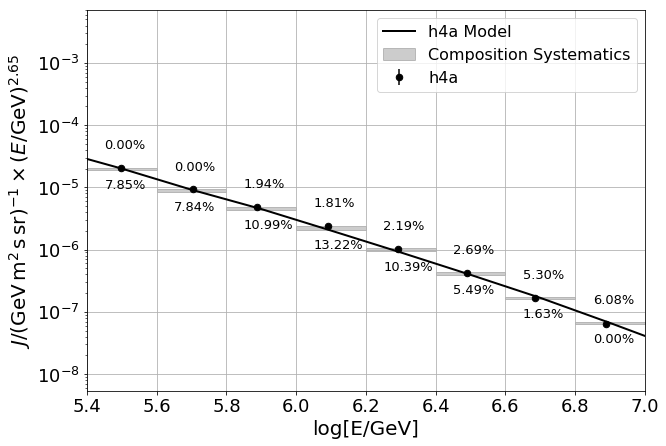

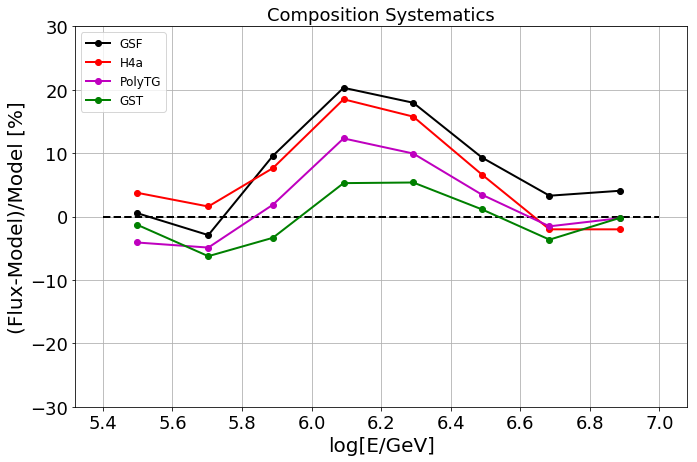

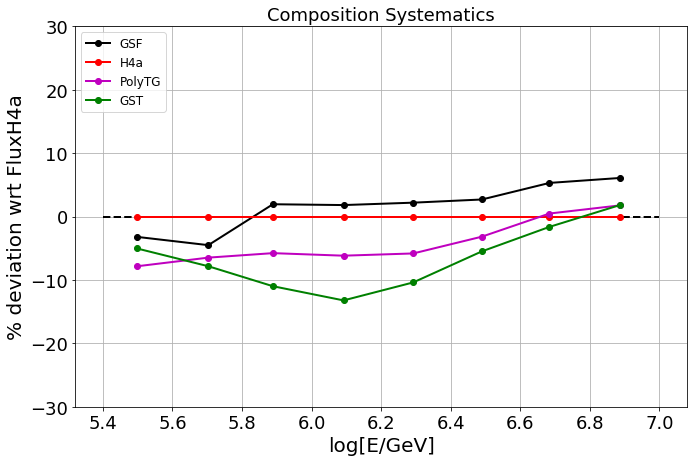

In [13]:
# Systematics for composition is the difference between the given composition model and its MC flux using Response
#   matrix generated by GSF composition Model.
# Several composition model is tried. Half of maximum difference is used as the composition systematics.

# This is also used for Hadronic interaction model systematics. So it is outside the 
#  'if' condition.
if len(mid_logE)==17:
    sys_y = numpy.arange(0,11.5,step=0.2)+0.1
elif len(mid_logE)==34:
    sys_y = numpy.arange(0,11.5,step=0.1)+0.05
sys_x = 10**sys_y

sys_bhak_bin = numpy.arange(4.0,7.4,0.2)+0.1
sys_bhak_mask= (sys_bhak_bin>=5.4)*(sys_bhak_bin<=7.0)

# Create mask to have energy bins equal to mid_logE
sys_ymask = (sys_y>=4.0)*(sys_y<=7.4)

model_scaling_factor = (10**mid_logE)**(scale-1.)

if which_systematics=='composition' or which_systematics=='all':

    if len(loge_bins)==18:
        """print 'Using proper Bhaktiyars style of composition systematics.'
        hf             = tables.open_file('flux_storage_temp%s.h5'%name)
        nameflux       = 'STA2_flux_exp_scale1_%s_%s_%s'%('scale_meanEtrue','jeffreys','all')
        nameflux80     = 'STA2_flux_exp_scale1_%s_%s_%s_cos80_90'%('scale_meanEtrue','jeffreys','all')
        flux_exp_all   = hf.get_node('/', nameflux)[:]
        flux_exp_all80 = hf.get_node('/', nameflux80)[:]            
        hf.close()"""
        print 'Using backup Bhaktiyars style of composition systematics.'
        hf = tables.open_file(rfr_savedir+'CR_flux_result_MC_h4a.h5')
        flux_exp_all   = hf.root.flux_scaled265_all_cos95[:-1]
        flux_exp_all80 = hf.root.flux_scaled265_all_cos80[:-1]    
        hf.close()

    elif len(loge_bins)==35:
        flux_exp_all    = numpy.array([2.92384906e-03,   3.08483114e-03,   2.72676452e-03,   2.39788947e-03,
                                       1.93825592e-03,   1.45515332e-03,   1.05100708e-03,   7.12889374e-04,
                                       4.68351273e-04,   2.95572600e-04,   1.82570892e-04,   1.11109099e-04,
                                       6.78082081e-05,   4.24110914e-05,   2.71601042e-05,   1.81096042e-05,
                                       1.23818885e-05,   8.63960899e-06,   6.06036259e-06,   4.21152860e-06,
                                       2.87306730e-06,   1.92615174e-06,   1.28232497e-06,   8.53834779e-07,
                                       5.66838999e-07,   3.70912997e-07,   2.40008819e-07,   1.52754056e-07,
                                       9.48943630e-08,   5.76111749e-08,   3.49134721e-08,   2.16712368e-08,
                                       1.58356210e-08,   1.36783784e-08])
        flux_exp_all80  = numpy.array([2.41636504e-03,   2.40977781e-03,   2.21087664e-03,   1.92113192e-03,
                                       1.62400356e-03,   1.27413737e-03,   9.56991316e-04,   6.80397727e-04,
                                       4.69225202e-04,   3.08317080e-04,   1.93967402e-04,   1.22870016e-04,
                                       7.51304986e-05,   4.64023043e-05,   2.88362560e-05,   1.85247253e-05,
                                       1.22690763e-05,   8.37704331e-06,   5.87996919e-06,   4.15453697e-06,
                                       2.92723993e-06,   2.03148459e-06,   1.38353934e-06,   9.35079442e-07,
                                       6.22823939e-07,   4.04904596e-07,   2.59976914e-07,   1.66196909e-07,
                                       1.04278442e-07,   6.37013438e-08,   3.92902351e-08,   2.45627770e-08,
                                       1.71507453e-08,   1.53709807e-08])
        
    model_gst  = model_scaling_factor*GST(particle='all', E=10**mid_logE)
    model_poly = model_scaling_factor*PolygonatoTG(particle='all', E=10**mid_logE)
    model_gsfM = ((sys_x**scale)*GSF(particle='all', E=sys_x, which_flux='median'))[sys_ymask]
    model_h4a  = model_scaling_factor*H4a(particle='all', E=10**mid_logE)

    # -ve value for lower bound, +ve value for upper bound.
    
    sys_gsfM = (fluxgsfM-model_gsfM)/model_gsfM
    sys_h4a  = (fluxh4a-model_h4a)/model_h4a
    sys_poly = (fluxpoly-model_poly)/model_poly
    sys_gst  = (fluxgst-model_gst)/model_gst
    sys_bhak = (flux_exp_all80-flux_exp_all)/flux_exp_all
    # Calculate deviation w.r.t systematics using H4a.
    sys_collection = sys_gsfM-sys_h4a # append rest on top of this array.
    sys_collection_temp = [sys_h4a-sys_h4a, sys_poly-sys_h4a, sys_gst-sys_h4a]
    if not isqgsjet:
        sys_collection_temp.append(sys_bhak-sys_h4a)
    for sys in sys_collection_temp:
        sys_collection = numpy.vstack((sys_collection, sys))
        
    sys_low  = numpy.min(sys_collection, axis=0)
    sys_high = numpy.max(sys_collection, axis=0)
    sys_low[numpy.where(sys_low>0)]  = 0.
    sys_high[numpy.where(sys_high<0)]  = 0.
    
    sys_low *= -1.
    print 'High:', sys_high[ene_mask]
    print 'Low:', sys_low[ene_mask]

    hf = tables.open_file('systematic_uncertainty%s.h5'%name, 'a')
    if 'composition_uncertainty_low' in hf.root:
        hf.remove_node('/', 'composition_uncertainty_low')
    if 'composition_uncertainty_high' in hf.root:
        hf.remove_node('/', 'composition_uncertainty_high')
    hf.create_array('/', 'composition_uncertainty_low', sys_low)
    hf.create_array('/', 'composition_uncertainty_high', sys_high)
    hf.close()
    
    #==========================================================================================
    # Plot Model-Model*/Model for each model.
    if composition_model=='h4a':
        baseflux = fluxh4a
        baseerr  = error_fluxh4a
        basemodel= model_h4a
    elif composition_model=='gsfM':
        baseflux = fluxgsfM
        baseerr  = error_fluxgsfM
        basemodel= model_gsfM
        
    plt.figure()
    label_bool = True
    for i in range(len(loge_bins)-1):
        if loge_bins[i]>=5.4 and loge_bins[i]<7:
            #if label_counter==0:
            plt.fill_between(loge_bins[i:i+2], (baseflux*(1. - sys_low))[i], (baseflux*(1. + sys_high))[i], 
                         color='k', alpha=0.2, label='Composition Systematics' if label_bool else '')
            label_bool=False
            plt.text(loge_bins[i]+0.05, 0.5*(baseflux*(1. - sys_low))[i], 
                     "%.2f"%abs(100*sys_low[i])+'%', fontsize=13)
            plt.text(loge_bins[i]+0.05, 2*(baseflux*(1. + sys_high))[i], 
                     "%.2f"%abs(100*sys_high[i])+'%', fontsize=13)
    plt.errorbar(mid_logE[ene_mask], baseflux[ene_mask], 
                 yerr=baseerr[ene_mask], 
                 markersize=6.5, color='k', fmt=' ', marker='o', label='%s'%composition_model)
    plt.plot(numpy.log10(sys_x[sys_ymask]), basemodel, 'k', lw=2, label='%s Model'%composition_model)            
    plt.yscale("log")
    plt.xlabel("log[E/GeV]")
    plt.ylabel(r"$J/(\mathrm{GeV\,m^2\,s\,sr})^{-1} \times (E/\mathrm{GeV})^{2.65}$")
    plt.xlim(5.4, 7)
    #plt.ylim(5e3, 1e5)
    plt.legend(loc='best', frameon=True)
    if savefig and do_h_fe:
        plt.title("cosmic-ray flux [H, Fe Only assumption]")
        plt.savefig(rfr_savedir+'composition_systematics_HFe_H4a.png', bbox_inches='tight')
    elif savefig and not do_h_fe:
        plt.title("cosmic-ray flux")
        plt.savefig(rfr_savedir+'composition_systematics_len%i'%len(mid_logE)+name+'.png', bbox_inches='tight')

    print 'here'
    #==========================================================================================
    # Plot Model-Model*/Model for each model.
    #plt.figure(figsize=(10, 6))
    plt.figure()
    plt.subplots_adjust(left=0.12, right=0.97)
    plt.plot(mid_logE[ene_mask], 100.*sys_gsfM[ene_mask], 'ko-', label='GSF', lw=2)
    plt.plot(mid_logE[ene_mask], 100.*sys_h4a[ene_mask], 'ro-', label='H4a', lw=2)
    plt.plot(mid_logE[ene_mask], 100.*sys_poly[ene_mask], 'mo-', label='PolyTG', lw=2)
    plt.plot(mid_logE[ene_mask], 100.*sys_gst[ene_mask], 'go-', label='GST', lw=2)
    if not isqgsjet:
        plt.plot(mid_logE[ene_mask], 100.*sys_bhak[ene_mask], 'co-', label='2 cos bins', lw=2)
    if do_h_fe:
        plt.plot(mid_logE[ene_mask], 100.*sys_h4aH[ene_mask],  'ro-', label='H', lw=2)
        plt.plot(mid_logE[ene_mask], 100.*sys_h4aFe[ene_mask], 'bo-', label='Fe', lw=2)
    plt.hlines(0,5.4,7, linestyle='--', lw=2)

    plt.xlabel("log[E/GeV]")
    plt.ylabel("(Flux-Model)/Model [%]")
    plt.ylim(-30, 30)
    plt.title("Composition Systematics")
    plt.legend(loc='upper left', fontsize=12, frameon=True)
    if savefig and do_h_fe:
        plt.savefig(rfr_savedir+'composition_systematics_percentage_HFe_H4a'+name+'.png', bbox_inches='tight')
    elif savefig and not do_h_fe:
        plt.savefig(rfr_savedir+'composition_systematics_percentage_len%i'%len(mid_logE)+name+'.png', bbox_inches='tight')

    #==========================================================================================
    # Plot systematics w.r.t H4a systematics for each model.
    #plt.figure(figsize=(10, 6))
    plt.figure()
    plt.subplots_adjust(left=0.12, right=0.97)
    plt.plot(mid_logE[ene_mask], 100.*(sys_gsfM-sys_h4a)[ene_mask], 'ko-', label='GSF', lw=2)
    plt.plot(mid_logE[ene_mask], 100.*(sys_h4a-sys_h4a)[ene_mask], 'ro-', label='H4a', lw=2)
    plt.plot(mid_logE[ene_mask], 100.*(sys_poly-sys_h4a)[ene_mask], 'mo-', label='PolyTG', lw=2)
    plt.plot(mid_logE[ene_mask], 100.*(sys_gst-sys_h4a)[ene_mask], 'go-', label='GST', lw=2)
    if not isqgsjet:
        plt.plot(mid_logE[ene_mask], 100.*(sys_bhak-sys_h4a)[ene_mask], 'co-', label='2 cos bins', lw=2)
    if do_h_fe:
        plt.plot(mid_logE[ene_mask], 100.*sys_h4aH[ene_mask],  'ro-', label='H', lw=2)
        plt.plot(mid_logE[ene_mask], 100.*sys_h4aFe[ene_mask], 'bo-', label='Fe', lw=2)
    plt.hlines(0,5.4,7, linestyle='--', lw=2)

    plt.xlabel("log[E/GeV]")
    plt.ylabel("% deviation wrt FluxH4a")
    plt.ylim(-30, 30)
    plt.title("Composition Systematics")
    plt.legend(loc='upper left', fontsize=12, frameon=True)
    if savefig:
        plt.savefig(rfr_savedir+'composition_systematics_percentage_wrtH4a_len%i'%len(mid_logE)+name+'.png', bbox_inches='tight')


In [14]:
print list(flux_exp_all)
print list(flux_exp_all80)

[29303.710246297735, 51115.9957780708, 68030.49532932547, 71705.14695856259, 60527.113730278594, 43852.717885977, 30983.10192299093, 25075.95451770228, 24160.640472497427, 24547.778808913197, 24058.65690927202, 22314.090595182202, 20264.28556748245, 17974.653851214483, 14711.904426942563, 11908.580970997866, 9908.39238780477]
[0.0, 1520.5609604394658, 5403.618967066956, 12015.517378709235, 20243.997561298373, 26524.471287484226, 27767.948688093278, 26276.713451890562, 24677.79214599934, 24262.998582924174, 24156.241960233016, 22993.479637325796, 20356.04834136017, 17157.726591367034, 14441.081697102825, 12241.652475475275, 10258.180263651351]


[23315.90737302 41696.17336446 52039.19307068 53031.60984436
 47708.06212336 38599.61934324 29617.38603282 24805.12527022
 25186.71324243 25045.92897236 25434.53731743 24119.12053546
 22427.42584548 19672.12474404 16527.47226279 13558.12487321
 13808.97354033]
[ 45.02303483  44.10482981  45.50616671  28.87967009  27.46262858
  30.62299057  31.34467284  35.26911941  54.64861668  81.19461135
 105.83548006 132.74032335 183.83464497 243.51730689 298.09584276
 373.78139301 599.47126735]
[-7.06007796 -7.40546127 -7.63959182 -7.6140484  -7.5009977  -7.72845385
 -8.28970654 -8.15616481]


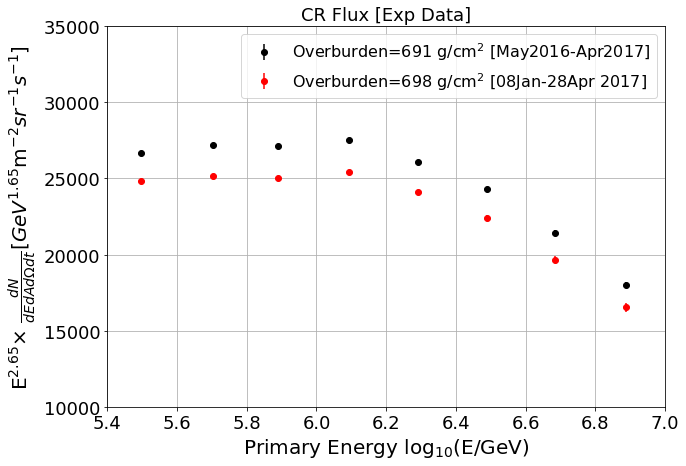

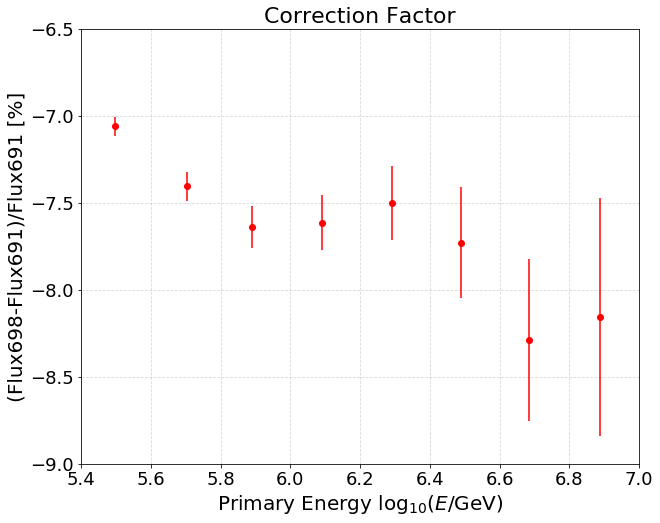

In [15]:
if which_systematics=='pressure' or which_systematics=='all': # composition, vemcal, pressure
    """
    CORSIKA Atmosphere: 698.12 g/cm2 see: https://wiki.icecube.wisc.edu/index.php/IceTop_LowEnergy_Spectrum
    Run used to get 698.12 g/cm2
    01Feb  - 31Mar 2017
    129030 - 129456

    expflux_overburden698 = numpy.array([  3.20652120e-03,   2.56796046e-03,   1.62608509e-03,   8.24661404e-04,
                                           3.50994288e-04,   1.32823508e-04,   4.92291429e-05,   2.01382426e-05,
                                           9.40283720e-06,   4.61851296e-06,   2.18335651e-06,   9.89221032e-07,
                                           4.35143852e-07,   1.85575248e-07,   7.11780523e-08,   2.69973984e-08,
                                           1.36667182e-08])"""
    expflux_overburden691 = numpy.array([0.004389096253392742, 0.0032812746407697557, 0.0020025414382166583, 
                                         0.00098408779067325172, 0.00040941078554126683, 0.00015171087903674169, 
                                         5.565188507300016e-05, 2.2681691793427307e-05, 1.0576651073672523e-05, 
                                         5.2065430522687067e-06, 2.4422908183993479e-06, 1.0803658920838029e-06, 
                                         4.7550343046983191e-07, 2.0056117498030274e-07, 7.7845060099278931e-08, 
                                         2.939230957404004e-08, 1.438409691517068e-08])
    expstat_overburden691 = numpy.array([4.637041206684265e-06, 1.8908865130771612e-06, 9.5034906304750672e-07, 
                                         2.9154751106132684e-07, 1.2851243757924486e-07, 6.5516762686699603e-08, 
                                         3.2111305808938709e-08, 1.766558336589002e-08, 1.2630495923968831e-08, 
                                         9.2690651425791727e-09, 5.5126378431037529e-09, 3.1966138654496847e-09, 
                                         2.0984299112231371e-09, 1.3474990520370444e-09, 7.6127067677783789e-10, 
                                         4.3911587891602388e-10, 3.3916285640749847e-10])

    expflux_overburden698 = numpy.array([0.0040054592830294942, 0.0030260290132878682, 0.001858289789539413, 
                                         0.00091734623160930919, 0.00038248292456370659, 0.00014177874222356457, 
                                         5.190241793186867e-05, 2.1080346669202962e-05, 9.7934012742736944e-06, 
                                         4.8087844149326688e-06, 2.256333613432388e-06, 9.993276714086339e-07, 
                                         4.3875436730891656e-07, 1.8393524214959744e-07, 7.1495888703585745e-08, 
                                         2.7044373613225143e-08, 1.3276215541682505e-08])
    expstat_overburden698 = numpy.array([7.7345449150414553e-06, 3.2008331670524708e-06, 1.6249991585780397e-06, 
                                         4.9956349809489097e-07, 2.201721475920269e-07, 1.1248010111672282e-07, 
                                         5.4929368447496949e-08, 2.997305015586231e-08, 2.1249133506279216e-08, 
                                         1.558925532667793e-08, 9.3888144365043615e-09, 5.4998306445024801e-09, 
                                         3.5964115498816893e-09, 2.2768976607004352e-09, 1.2895273311168356e-09, 
                                         7.4558124642124104e-10, 5.7634332726763978e-10])

    scale = 2.65
    scale_factor = (10**mid_logE)**(scale-1.)
    print scale_factor*expflux_overburden698
    print scale_factor*expstat_overburden698
    plt.figure()
    plt.errorbar(mid_logE, scale_factor*expflux_overburden691, yerr=scale_factor*expstat_overburden691, 
                 color='k', marker='o', linestyle='', label=r'Overburden=691 g/cm$^2$ [May2016-Apr2017]')
    plt.errorbar(mid_logE, scale_factor*expflux_overburden698, yerr=scale_factor*expstat_overburden698, 
                 color='r', marker='o', linestyle='', label=r'Overburden=698 g/cm$^2$ [08Jan-28Apr 2017]')
    #plt.yscale('log')
    plt.xlim(5.4, 7.0)
    plt.ylim(10e3,35e3)
    plt.legend(loc='best', frameon=True)
    plt.xlabel('Primary Energy ' +r'log$_{10}$(E/GeV)')
    plt.ylabel(r'E$^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$GeV^{'+str(scale-1)+'}$' +r'm$^{-2}sr^{-1}s^{-1}$]')
    plt.title('CR Flux [Exp Data]')
    if savefig:
        plt.savefig(rfr_savedir+'pressure_flux_experiment%s_len%i.png'%(name,len(mid_logE)), bbox_inches='tight')

        
    presdiff = expflux_overburden698-expflux_overburden691
    pressys  = presdiff/expflux_overburden691
    preslow  = pressys.copy()
    preshigh = pressys.copy()
    preslow[numpy.where(preslow>0)]=0
    preshigh[numpy.where(preshigh<0)]=0
    
    plt.figure(figsize=(10,8))    
    print 100.*pressys[ene_mask]
    preserr  = errorXbyY(presdiff, expflux_overburden691, expstat_overburden698-expstat_overburden691, expstat_overburden691)
    plt.errorbar(mid_logE, 100.*pressys, yerr=100.*preserr, 
                 color='r', marker='o', linestyle='')
    plt.xlim(5.4, 7.0)
    plt.ylim(-9,-6.5)
    plt.grid(ls='--', alpha=0.5)
    #plt.legend(loc='best', frameon=True)
    plt.xlabel('Primary Energy ' +r'log$_{10}$($E$/GeV)')
    plt.ylabel(r'(Flux698-Flux691)/Flux691 [%]')
    plt.title("Correction Factor", fontsize=22)
    if savefig:
        plt.savefig(rfr_savedir+'pressure_systematic_uncertainty%s_len%i.png'%(name,len(mid_logE)), 
                    bbox_inches='tight')

    # Note: The fractional difference is used to correct the final spectrum and the error second plot is used
    # as the systematic error due to pressure.
    hf = tables.open_file('systematic_uncertainty%s.h5'%name, 'a')
    if 'pressure_uncertainty_low' in hf.root:
        hf.remove_node('/', 'pressure_uncertainty_low')
        hf.remove_node('/', 'pressure_uncertainty_high')
        hf.remove_node('/', 'pressure_flux_shift')
    hf.create_array('/', 'pressure_uncertainty_low', preserr)
    hf.create_array('/', 'pressure_uncertainty_high', preserr)
    hf.create_array('/', 'pressure_flux_shift', -1.*preslow)
    hf.close()


In [16]:
print list((scale_factor*expflux_overburden698)[ene_mask])
print list((scale_factor*expstat_overburden698)[ene_mask])
print len(mid_logE[ene_mask])
print ene_mask

[24805.12527021546, 25186.713242428366, 25045.928972355003, 25434.537317428887, 24119.120535460224, 22427.42584547713, 19672.12474403866, 16527.472262791303]
[35.26911940840139, 54.64861668424004, 81.19461135155697, 105.83548005935914, 132.74032335399127, 183.83464497345847, 243.51730689151572, 298.0958427624371]
8
[False False False False False False False  True  True  True  True  True
  True  True  True False False]


[ 0.          0.          0.          0.          0.          0.
  0.         -0.00672989 -0.00510581 -0.00335597 -0.00342298 -0.00394879
 -0.00817463 -0.00431049 -0.01512686  0.          0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.01021249 0.00719635 0.0041628  0.00499131 0.00737259
 0.00716314 0.00547924 0.02061256 0.         0.        ]


/Users/rameshkoirala/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


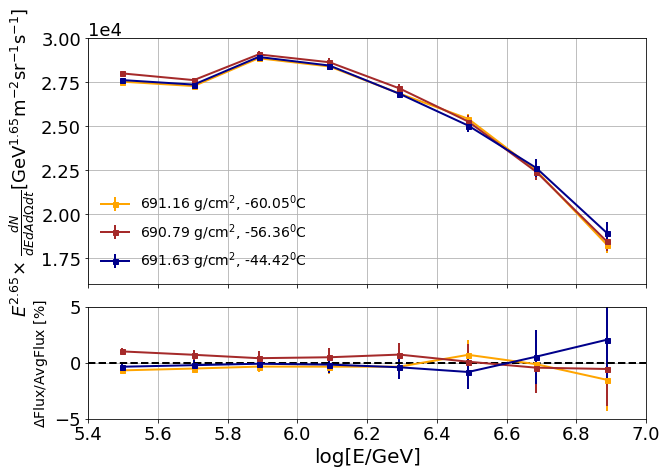

In [17]:
'''
Data with fixed pressure (~691.16 g/cm^2) and different temperature is used to 
see the effect of temperature on flux.
These values are calculated on analysis_ML.ipynb
'''
flx_pres691_0 = numpy.array([27534.320150142677, 27283.910090166104, 28864.501767071582, 28397.112258598252, 26861.765007357058, 25422.555775987901, 22489.432704558447, 18273.342777338559])
err_pres691_0 = numpy.array([56.467617350185826, 84.972294509453974, 133.0426194854991, 166.38801438596522, 206.6018054394001, 291.56040652539258, 386.82016166489223, 456.79011302228571])
flx_pres691_1 = numpy.array([28003.977781047157, 27621.283833578214, 29082.257997930818, 28636.874710189444, 27152.771246664106, 25267.277343772017, 22418.694219388821, 18452.225090347605])
err_pres691_1 = numpy.array([72.065129866665572, 109.54837167062169, 172.14334034557149, 215.76662347595592, 266.8405294799577, 359.79879478798006, 476.64503552967085, 571.93331759355237])
flx_pres691_2 = numpy.array([27624.337764301141, 27366.600823686735, 28938.329398170259, 28449.959865651825, 26847.614396026984, 25035.403507047577, 22639.117134227505, 18936.452323681275])
err_pres691_2 = numpy.array([73.048537007030546, 108.5781229115249, 167.85000245765912, 209.40238030837639, 259.08977971893671, 356.45544736804857, 504.15564055199809, 638.9273411734581])

mid_flux691 = (flx_pres691_0+flx_pres691_1+flx_pres691_2)/3.
mid_err691  = 0.25*numpy.sqrt(err_pres691_0**2+err_pres691_1**2+err_pres691_2**2)
sys_frac_temp0 = (flx_pres691_0-mid_flux691)/mid_flux691
sys_frac_temp1 = (flx_pres691_1-mid_flux691)/mid_flux691
sys_frac_temp2 = (flx_pres691_2-mid_flux691)/mid_flux691
err_sys_temp0  = errorXbyY(flx_pres691_0-mid_flux691,mid_flux691, numpy.sqrt(err_pres691_0**2+mid_err691**2), mid_err691)
err_sys_temp1  = errorXbyY(flx_pres691_1-mid_flux691,mid_flux691, numpy.sqrt(err_pres691_1**2+mid_err691**2), mid_err691)
err_sys_temp2  = errorXbyY(flx_pres691_2-mid_flux691,mid_flux691, numpy.sqrt(err_pres691_2**2+mid_err691**2), mid_err691)

sys_collection = [sys_frac_temp0]
sys_collection_temp = [sys_frac_temp1, sys_frac_temp2]
for sys in sys_collection_temp:
    sys_collection = numpy.vstack((sys_collection, sys))

sys_low  = numpy.min(sys_collection, axis=0)
sys_high = numpy.max(sys_collection, axis=0)
sys_low[numpy.where(sys_low>0)]  = 0.
sys_high[numpy.where(sys_high<0)]  = 0.
# This is to fill the mased energy region with zeros. Find out proper values if you want to use those energy bin.
sys_low = numpy.concatenate((numpy.zeros(7),sys_low, numpy.zeros(2)))
sys_high = numpy.concatenate((numpy.zeros(7),sys_high, numpy.zeros(2)))

hf                     = tables.open_file('systematic_uncertainty%s.h5'%name, 'a')
if 'temperature_uncertainty_low' in hf.root:
    hf.remove_node('/', 'temperature_uncertainty_low')
    hf.remove_node('/', 'temperature_uncertainty_high')
hf.create_array('/', 'temperature_uncertainty_low', sys_low)
hf.create_array('/', 'temperature_uncertainty_high', sys_high)
hf.close()
print sys_low
print sys_high

plt.figure()
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[:2, :])
ax2 = plt.subplot(gs[2, :], sharex=ax1)
ax1.errorbar(mid_logE[ene_mask], flx_pres691_0, yerr=err_pres691_0, color='orange', alpha=1, 
             linestyle='-', fmt='s', markersize=5, label=r'691.16 g/cm$^2$, -60.05$^0$C', lw=2)
ax1.errorbar(mid_logE[ene_mask], flx_pres691_1, yerr=err_pres691_1, color='brown', alpha=1, 
             linestyle='-', fmt='s', markersize=5, label=r'690.79 g/cm$^2$, -56.36$^0$C', lw=2)
ax1.errorbar(mid_logE[ene_mask], flx_pres691_2, yerr=err_pres691_2, color='darkblue', linestyle='-', fmt='s', markersize=5, 
             label=r'691.63 g/cm$^2$, -44.42$^0$C', lw=2)

ax2.errorbar(mid_logE[ene_mask], 100*sys_frac_temp0, yerr=100*err_sys_temp0, color='orange', linestyle='-', fmt='s', markersize=5, lw=2)
ax2.errorbar(mid_logE[ene_mask], 100*sys_frac_temp1, yerr=100*err_sys_temp1, color='brown', linestyle='-', fmt='s', markersize=5, lw=2)
ax2.errorbar(mid_logE[ene_mask], 100*sys_frac_temp2, yerr=100*err_sys_temp2, color='darkblue', linestyle='-', fmt='s', markersize=5, lw=2)
ax2.hlines(0,5.4,7, linestyle='--', lw=2, color='k')
ax1.tick_params(labelbottom='off')
ax1.set_ylabel(r'$E^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$\rm GeV^{1.65}m^{-2}sr^{-1}s^{-1}$]',
               fontsize=18)
ax1.legend(loc='best', frameon=False, fontsize=14, numpoints=1)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.set_ylim(16e3,30e3)
ax2.set_xlabel('log[E/GeV]')
ax2.set_ylabel(r'$\Delta$Flux/AvgFlux [%]', fontsize=14)
ax2.set_ylim(-5,5)
plt.xlim(5.4, 7.0)
if savefig:
    fn='systematics_temp_fixed_pressure_%s_%s%s.png'%(composition_model,particle,name)
    plt.savefig(rfr_savedir+fn, bbox_inches='tight')


Ngenerated shower for a given zenith bin. Particle:  all
17 17
Sys Low due to effective area [%].
[1095.19832694  540.02594357  433.90290613  325.48778167  197.82743872
  100.41771738   48.3923588    13.00789597    7.82216067    5.80246784
    3.61761222    3.02049543    2.87225292    2.83676564    2.82810538
    2.8262319     2.82584568]
Sys High due to effective area [%]
[91.27330529 90.15405733 84.82938998 77.3409282  68.96133967 57.86011012
 36.20028384  6.22152676  7.00037719  3.75211617  2.92324171  2.72057043
  2.6823931   2.67585021  2.6747836   2.67461     2.67458228]


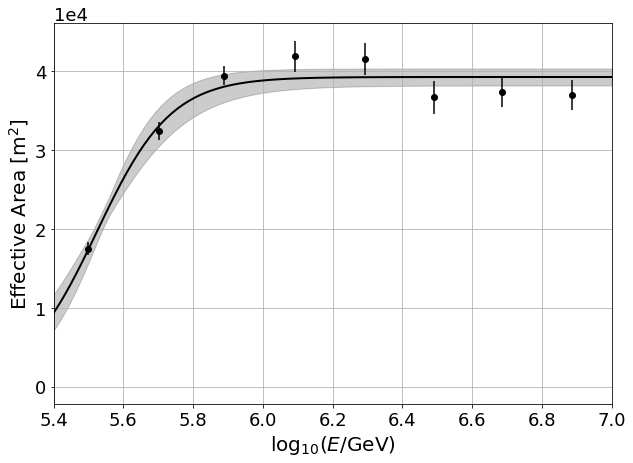

In [18]:
# ==========================================================================
# ====================== Effective Area ==================================
# ==========================================================================
logenex = numpy.linspace(5.4,7.0,100)
eff, error_eff  = efficiency(tenergy, weighth4a,
                             loge_bins=loge_bins,
                             particle='all',
                             composition_model='h4a'
                            )
AeffO           = effective_area(eff, loge_bins) # Aeff before fitting.
ErrAeff         = effective_area(error_eff, loge_bins)
Aeff,popt_eff, pcov_eff   = effective_area(eff, loge_bins, fitted=True)


ka_err = numpy.sqrt(numpy.diag(pcov_eff))

sys_collection = Aeff
aeff_fit = sigmoid_func(logenex, *popt_eff)
sys_collection_smooth = aeff_fit
kap0_list = numpy.array([ka_err[0], 0., 0.])
kap1_list = numpy.array([0., ka_err[1], 0.])
kap2_list = numpy.array([0., 0., ka_err[2]])
for i in range(3):#p0
    for j in range(3):#p1
        for k in range(3):#p2
            kha_err   = numpy.array([kap0_list[i], kap1_list[j], kap2_list[k]])
            ka_popt_p = popt_eff+kha_err
            ka_popt_m = popt_eff-kha_err
            aeff_p = sigmoid_func(mid_logE, *ka_popt_p)
            aeff_m = sigmoid_func(mid_logE, *ka_popt_m)
            aeff_p_smooth = sigmoid_func(logenex, *ka_popt_p)
            aeff_m_smooth = sigmoid_func(logenex, *ka_popt_m)
            
            sys_collection_smooth = numpy.vstack((sys_collection_smooth, aeff_p_smooth))
            sys_collection_smooth = numpy.vstack((sys_collection_smooth, aeff_m_smooth))
            
            sys_collection = numpy.vstack((sys_collection, aeff_p))
            sys_collection = numpy.vstack((sys_collection, aeff_m))
    
aeff_m = numpy.min(sys_collection, axis=0)
aeff_p = numpy.max(sys_collection, axis=0)
aeff_m_smooth = numpy.min(sys_collection_smooth, axis=0)
aeff_p_smooth = numpy.max(sys_collection_smooth, axis=0)

# Fraction of flux difference if different effictive are has been used.
# Remember dN/... remains the same except effective area, and they cancel
# out while taking the ratio.
sys_aeff_low  = -1.*((1./Aeff - 1./aeff_m)/(1./Aeff))
sys_aeff_high = ((1./Aeff - 1./aeff_p)/(1./Aeff))

hf = tables.open_file('systematic_uncertainty%s.h5'%name, 'a')
if 'effective_area_uncertainty_low' in hf.root:
    hf.remove_node('/', 'effective_area_uncertainty_low')
    hf.remove_node('/', 'effective_area_uncertainty_high')
hf.create_array('/', 'effective_area_uncertainty_low', sys_aeff_low)
hf.create_array('/', 'effective_area_uncertainty_high', sys_aeff_high)
hf.close()

print 'Sys Low due to effective area [%].'
print 100.*sys_aeff_low
print 'Sys High due to effective area [%]'
print 100.*sys_aeff_high

plt.figure()
#plt.plot(mid_logE, Aeff, 'k', lw=2)
plt.plot(logenex, sigmoid_func(logenex, *popt_eff), 'k', lw=2)
plt.fill_between(logenex, aeff_m_smooth, aeff_p_smooth, color='k', alpha=0.2)
plt.errorbar(mid_logE, AeffO, yerr=ErrAeff, color='k', marker='o', linestyle='')
plt.xlabel(r'log$_{10}$($E$/GeV)')
plt.ylabel(r'Effective Area [m$^2$]')
#plt.title(r'Error on Effective Area [cos$\theta$>=0.9]', fontsize=12)
plt.xlim(5.4,7.0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
if savefig:
#if True:
    figname='effective_area_band%s'%name+'.png'
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')




Ngenerated shower for a given zenith bin. Particle:  all
17 17

Ngenerated shower for a given zenith bin. Particle:  all
17 17

Ngenerated shower for a given zenith bin. Particle:  all
17 17

Ngenerated shower for a given zenith bin. Particle:  all
17 17


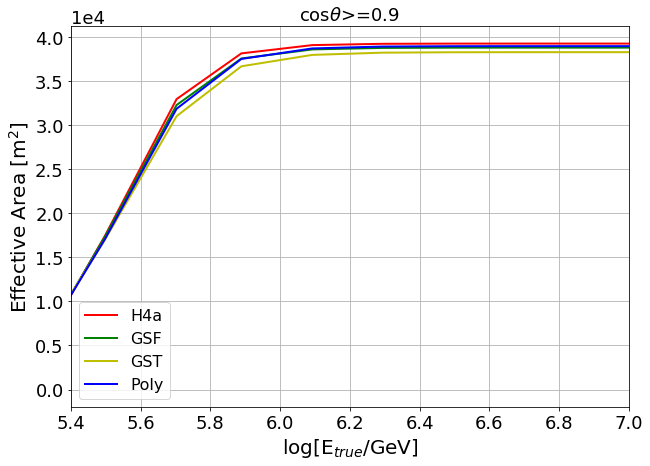

In [19]:
# H4a
eff_h4a, error_eff_h4a  = efficiency(tenergy, weighth4a,
                             loge_bins=loge_bins,
                             particle='all',
                             composition_model='h4a'
                            )
AeffO_h4a           = effective_area(eff_h4a, loge_bins) # Aeff before fitting.
ErrAeff_h4a         = effective_area(error_eff_h4a, loge_bins)
Aeff_h4a,popt_eff_h4a, pcov_eff_h4a   = effective_area(eff_h4a, loge_bins, fitted=True)

# GSF
eff_gsf, error_eff_gsf  = efficiency(tenergy, weightgsfM,
                             loge_bins=loge_bins,
                             particle='all',
                             composition_model='gsfM'
                            )
AeffO_gsf           = effective_area(eff_gsf, loge_bins) # Aeff before fitting.
ErrAeff_gsf         = effective_area(error_eff_gsf, loge_bins)
Aeff_gsf,popt_eff_gsf, pcov_eff_gsf   = effective_area(eff_gsf, loge_bins, fitted=True)

# GST
eff_gst, error_eff_gst  = efficiency(tenergy, weightgst,
                             loge_bins=loge_bins,
                             particle='all',
                             composition_model='gst'
                            )
AeffO_gst           = effective_area(eff_gst, loge_bins) # Aeff before fitting.
ErrAeff_gst         = effective_area(error_eff_gst, loge_bins)
Aeff_gst,popt_eff_gst, pcov_eff_gst   = effective_area(eff_gst, loge_bins, fitted=True)

# Poly
eff_poly, error_eff_poly  = efficiency(tenergy, weightpoly,
                             loge_bins=loge_bins,
                             particle='all',
                             composition_model='poly'
                            )
AeffO_poly          = effective_area(eff_h4a, loge_bins) # Aeff before fitting.
ErrAeff_poly        = effective_area(error_eff_h4a, loge_bins)
Aeff_poly,popt_eff_poly, pcov_eff_poly   = effective_area(eff_poly, loge_bins, fitted=True)



plt.figure()
plt.plot(mid_logE, Aeff_h4a, 'r', label='H4a', lw=2)
plt.plot(mid_logE, Aeff_gsf, 'g', label='GSF', lw=2)
plt.plot(mid_logE, Aeff_gst, 'y', label='GST', lw=2)
plt.plot(mid_logE, Aeff_poly, 'b', label='Poly', lw=2)
plt.xlabel(r'log[E$_{true}$/GeV]')
plt.ylabel(r'Effective Area [m$^2$]')
plt.title(r'cos$\theta$>=0.9')
plt.xlim(5.4,7.0)
plt.legend(loc='best')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
if savefig:
    figname='effective_area_various_composition_model%s'%name+'.png'
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')


In [20]:
# systematic error due to error on duration calcuation.
duration  = 28548809.85074771
durationH = 28609806.45698332 # fit with +sigma
durationL = 28487813.24451206 # fit with -sigma

# Flux is proportional to dN/dt.... Everything else except dt cancel out and the only thing thats left is 1/dt.
sys_dur_high = (1./duration-1./durationH)/(1./duration)
sys_dur_low = ((1./durationL)-(1./duration))/(1./duration)

hf = tables.open_file('systematic_uncertainty%s.h5'%name, 'a')
if 'duration_uncertainty_low' in hf.root:
    hf.remove_node('/', 'duration_uncertainty_low')
    hf.remove_node('/', 'duration_uncertainty_high')

hf.create_array('/', 'duration_uncertainty_low', numpy.array([sys_dur_low]))
hf.create_array('/', 'duration_uncertainty_high', numpy.array([sys_dur_high]))
hf.close()

print 'systematic due to duration'
print 100*sys_dur_high, '%'
print 100*sys_dur_low, '%'

systematic due to duration
0.2132017437 %
0.214114736404 %


In [22]:
import tables
import matplotlib.pyplot as plt

hf                     = tables.open_file('systematic_uncertainty%s.h5'%name)
sys_comp_low_frac      = hf.root.composition_uncertainty_low[:]
sys_comp_high_frac     = hf.root.composition_uncertainty_high[:]

sys_aeff_low_frac      = hf.root.effective_area_uncertainty_low[:]
sys_aeff_high_frac     = hf.root.effective_area_uncertainty_high[:]

# This is not the pressure correction ~5%. This is the error on shift of rate due to different pressure.
sys_pressure_low_frac  = hf.root.pressure_uncertainty_low[:]
sys_pressure_high_frac = hf.root.pressure_uncertainty_high[:]

sys_duration_low_frac  = hf.root.duration_uncertainty_low[:]
sys_duration_high_frac = hf.root.duration_uncertainty_high[:]

if isqgsjet:
    sys_unfolding_low_frac = hf.root.unfolding_uncertainty_exp_len17[:]
    sys_unfolding_high_frac= hf.root.unfolding_uncertainty_exp_len17[:]
else:
    sys_unfolding_low_frac = hf.root.unfolding_uncertainty_exp[:]
    sys_unfolding_high_frac= hf.root.unfolding_uncertainty_exp[:]

hf.close()

sys_low_frac  = systematics_quadrature([sys_comp_low_frac, 
                                        sys_aeff_low_frac,
                                        sys_pressure_low_frac,
                                        sys_duration_low_frac,
                                        sys_unfolding_low_frac
                                       ])
sys_high_frac  = systematics_quadrature([sys_comp_high_frac, 
                                        sys_aeff_high_frac,
                                        sys_pressure_high_frac,
                                        sys_duration_high_frac,
                                        sys_unfolding_high_frac
                                       ])
# mid of logE just for plotting, especially for total systematics.
midlogE = 0.5*(loge_bins[1:]+loge_bins[:-1])

plt.figure()
# composition
for i in range(len(midlogE)):
    if i==0:
        plt.fill_between(loge_bins[i:i+2], (-100*sys_comp_low_frac)[i], 
                     (100*sys_comp_high_frac)[i], color='k', alpha=0.15, label='Composition') 
    else:
        plt.fill_between(loge_bins[i:i+2], (-100*sys_comp_low_frac)[i], 
                     (100*sys_comp_high_frac)[i], color='k', alpha=0.15) 

# Unfolding
sys_unfolding_low_frac
for i in range(len(midlogE)):
    if i==0:
        plt.fill_between(loge_bins[i:i+2], (-100*sys_unfolding_low_frac)[i], 
                     (100*sys_unfolding_high_frac)[i], color='r', alpha=0.25, label='Unfolding') 
    else:
        plt.fill_between(loge_bins[i:i+2], (-100*sys_unfolding_low_frac)[i], 
                     (100*sys_unfolding_high_frac)[i], color='r', alpha=0.25) 

# Pressure
for i in range(len(midlogE)):
    if i==0:
        plt.fill_between(loge_bins[i:i+2], (-100*sys_pressure_low_frac)[i], 
                     (100*sys_pressure_high_frac)[i], color='g', alpha=0.7, label='Pressure') 
    else:
        plt.fill_between(loge_bins[i:i+2], (-100*sys_pressure_low_frac)[i], 
                     (100*sys_pressure_high_frac)[i], color='g', alpha=0.7) 

# Effective area
for i in range(len(midlogE)):
    if i==0:
        plt.fill_between(loge_bins[i:i+2], (-100*sys_aeff_low_frac)[i], 
                     (100*sys_aeff_high_frac)[i], color='b', alpha=0.3, label='Aeff') 
    else:
        plt.fill_between(loge_bins[i:i+2], (-100*sys_aeff_low_frac)[i], 
                     (100*sys_aeff_high_frac)[i], color='b', alpha=0.3) 

# Duration
plt.fill_between(loge_bins, -100*sys_duration_low_frac[0], 100*sys_duration_high_frac[0], 
                 color='c', alpha=0.2, label='Duration') 

plt.step(midlogE, -100*sys_low_frac, color='k', lw=2, where='mid', linestyle='--', label='Total')
plt.step(midlogE, 100*sys_high_frac, color='k', lw=2, where='mid', linestyle='--')

print 'All systematic uncertainty in the same plot.'
plt.xlim(5.4,7.0)
plt.ylim(-12,12)
plt.legend(loc='lower right', fontsize=14)
plt.xlabel('log[E/GeV]')
plt.ylabel('Systematic Uncertainty [%]')
if savefig:
    figname='systematic_uncertainty_all%s'%name+'.png'
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')
    

NoSuchNodeError: group ``/`` does not have a child named ``unfolding_uncertainty_exp_len17``

In [ ]:
import tables
import matplotlib.pyplot as plt

hf                     = tables.open_file('systematic_uncertainty%s.h5'%name)
#hf                     = tables.open_file('systematic_uncertainty_10dec2018.h5')
sys_comp_low_frac      = hf.root.composition_uncertainty_low[:]
sys_comp_high_frac     = hf.root.composition_uncertainty_high[:]

sys_aeff_low_frac      = hf.root.effective_area_uncertainty_low[:]
sys_aeff_high_frac     = hf.root.effective_area_uncertainty_high[:]

# This is not the pressure correction ~5%. This is the error on shift of rate due to different pressure.
sys_pressure_low_frac  = hf.root.pressure_uncertainty_low[:]
sys_pressure_high_frac = hf.root.pressure_uncertainty_high[:]
# This calculation is done above. Values for final flux is from analysis_ML.ipynb
sys_temp_low_frac  = hf.root.temperature_uncertainty_low[:]
sys_temp_high_frac = hf.root.temperature_uncertainty_high[:]
sys_pres_plus_temp_low = sys_pressure_low_frac-sys_temp_low_frac
sys_pres_plus_temp_high= sys_pressure_high_frac+sys_temp_high_frac

sys_duration_low_frac  = hf.root.duration_uncertainty_low[:]
sys_duration_high_frac = hf.root.duration_uncertainty_high[:]

sys_unfolding_low_frac = hf.root.unfolding_uncertainty_exp[:]
sys_unfolding_high_frac= hf.root.unfolding_uncertainty_exp[:]
hf.close()

sys_low_frac  = systematics_quadrature([sys_comp_low_frac, 
                                        sys_aeff_low_frac,
                                        sys_pres_plus_temp_low,
                                        #sys_duration_low_frac,
                                        sys_unfolding_low_frac
                                       ])
sys_high_frac  = systematics_quadrature([sys_comp_high_frac, 
                                        sys_aeff_high_frac,
                                        sys_pres_plus_temp_high,
                                        #sys_duration_high_frac,
                                        sys_unfolding_high_frac
                                       ])
# mid of logE just for plotting, especially for total systematics.
midlogE = 0.5*(loge_bins[1:]+loge_bins[:-1])

alphaB = 0.6
plt.figure()
#Total
l5=plt.bar(midlogE-0.1, -100*sys_low_frac, width=0.2, color='lightgray', lw=1.5, edgecolor='k')
plt.bar(midlogE-0.1, 100*sys_high_frac, width=0.2, color='lightgray', lw=1.5, edgecolor='k')
# composition
l1=plt.bar(midlogE-0.1, -100*sys_comp_low_frac, width=0.05, color='r', alpha=alphaB)
plt.bar(midlogE-0.1, 100*sys_comp_high_frac, width=0.05, color='r', alpha=alphaB)
# Unfolding
l2=plt.bar(midlogE-0.05, -100*sys_unfolding_low_frac, width=0.05, color='orange', alpha=alphaB) 
plt.bar(midlogE-0.05, 100*sys_unfolding_high_frac, width=0.05, color='orange', alpha=alphaB) 
# Effective area
l3=plt.bar(midlogE, -100*sys_aeff_low_frac, width=0.05, color='steelblue', alpha=alphaB) 
plt.bar(midlogE, 100*sys_aeff_high_frac, width=0.05, color='steelblue', alpha=alphaB) 
# Pressure
#l4=plt.bar(midlogE+0.05, -100*sys_pressure_low_frac, width=0.05, color='darkblue', alpha=alphaB, label='Pressure') 
#plt.bar(midlogE+0.05, 100*sys_pressure_high_frac, width=0.05, color='darkblue', alpha=alphaB) 
# Atmosphere (Pressure + Temperature)
l4=plt.bar(midlogE+0.05, -100*sys_pres_plus_temp_low, width=0.05, color='darkblue', alpha=alphaB) 
plt.bar(midlogE+0.05, 100*sys_pres_plus_temp_high, width=0.05, color='darkblue', alpha=alphaB) 

print 'All systematic uncertainty in the same plot.'
plt.xlim(5.4,7.0)
plt.ylim(-12,12)
plt.legend([l5[0], l1[0],l2[0],l3[0],l4[0]], ['Total', 'Composition', 'Unfolding', 'Effective Area', 'Atmosphere'],
           loc='best', fontsize=14.5)
plt.xlabel(r'log$_{10}(E/\rm GeV)$')
plt.ylabel('Systematic Uncertainty [%]')
plt.ylim(-15,15)
#if True:
if savefig:
    figname='systematic_uncertainty_all_colorblind%s'%name+'.png'
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')
    

In [ ]:
import tables
import matplotlib.pyplot as plt

# This is used after my computer crashed and everything new has been installed.

hf                     = tables.open_file('systematic_uncertainty%s.h5'%name)
#hf                     = tables.open_file('systematic_uncertainty_10dec2018.h5')
sys_comp_low_frac      = hf.root.composition_uncertainty_low[:]
sys_comp_high_frac     = hf.root.composition_uncertainty_high[:]

sys_aeff_low_frac      = hf.root.effective_area_uncertainty_low[:]
sys_aeff_high_frac     = hf.root.effective_area_uncertainty_high[:]

# This is not the pressure correction ~5%. This is the error on shift of rate due to different pressure.
sys_pressure_low_frac  = hf.root.pressure_uncertainty_low[:]
sys_pressure_high_frac = hf.root.pressure_uncertainty_high[:]
# This calculation is done above. Values for final flux is from analysis_ML.ipynb
sys_temp_low_frac  = hf.root.temperature_uncertainty_low[:]
sys_temp_high_frac = hf.root.temperature_uncertainty_high[:]
sys_pres_plus_temp_low = sys_pressure_low_frac-sys_temp_low_frac
sys_pres_plus_temp_high= sys_pressure_high_frac+sys_temp_high_frac

sys_duration_low_frac  = hf.root.duration_uncertainty_low[:]
sys_duration_high_frac = hf.root.duration_uncertainty_high[:]

sys_unfolding_low_frac = hf.root.unfolding_uncertainty_exp[:]
sys_unfolding_high_frac= hf.root.unfolding_uncertainty_exp[:]
hf.close()

sys_low_frac  = systematics_quadrature([sys_comp_low_frac, 
                                        sys_aeff_low_frac,
                                        sys_pres_plus_temp_low,
                                        #sys_duration_low_frac,
                                        sys_unfolding_low_frac
                                       ])
sys_high_frac  = systematics_quadrature([sys_comp_high_frac, 
                                        sys_aeff_high_frac,
                                        sys_pres_plus_temp_high,
                                        #sys_duration_high_frac,
                                        sys_unfolding_high_frac
                                       ])

print '\nTotal systematic uncertainty [%]'
print '\thigh:', numpy.around(100*sys_high_frac[ene_mask], 3)
print '\tlow:', numpy.around(100*sys_low_frac[ene_mask], 3)

# mid of logE just for plotting, especially for total systematics.
midlogE = 0.5*(loge_bins[1:]+loge_bins[:-1])

alphaB = 0.6
plt.figure(figsize=(10,7))
#if True:
#Total
l5=plt.bar(midlogE, -100*sys_low_frac, width=0.2, color='lightgray', lw=1.5, edgecolor='k')
plt.bar(midlogE, 100*sys_high_frac, width=0.2, color='lightgray', lw=1.5, edgecolor='k')
# composition
l1=plt.bar(midlogE-0.075, -100*sys_comp_low_frac, width=0.05, color='r', alpha=alphaB, edgecolor='k')
plt.bar(midlogE-0.075, 100*sys_comp_high_frac, width=0.05, color='r', alpha=alphaB, edgecolor='k')
# Unfolding
l2=plt.bar(midlogE-0.025, -100*sys_unfolding_low_frac, width=0.05, color='orange', alpha=alphaB, edgecolor='k') 
plt.bar(midlogE-0.025, 100*sys_unfolding_high_frac, width=0.05, color='orange', alpha=alphaB, edgecolor='k') 
# Effective area
l3=plt.bar(midlogE+0.025, -100*sys_aeff_low_frac, width=0.05, color='steelblue', alpha=alphaB, edgecolor='k') 
plt.bar(midlogE+0.025, 100*sys_aeff_high_frac, width=0.05, color='steelblue', alpha=alphaB, edgecolor='k') 
# Pressure
#l4=plt.bar(midlogE+0.05, -100*sys_pressure_low_frac, width=0.05, color='darkblue', alpha=alphaB, label='Pressure') 
#plt.bar(midlogE+0.05, 100*sys_pressure_high_frac, width=0.05, color='darkblue', alpha=alphaB) 
# Atmosphere (Pressure + Temperature)
l4=plt.bar(midlogE+0.075, -100*sys_pres_plus_temp_low, width=0.05, color='darkblue', alpha=alphaB, edgecolor='k') 
plt.bar(midlogE+0.075, 100*sys_pres_plus_temp_high, width=0.05, color='darkblue', alpha=alphaB, edgecolor='k') 

plt.hlines(0, 5.4, 7.0, color='k')
print 'All systematic uncertainty in the same plot.'
plt.xlim(5.4,7.0)
plt.legend([l5[0], l1[0],l2[0],l3[0],l4[0]], ['Total', 'Composition', 'Unfolding', 'Effective Area', 'Atmosphere'],
           loc='best', fontsize=14.5)
plt.xlabel(r'log$_{10}(E/\rm GeV)$')
plt.ylabel('Systematic Uncertainty [%]')
plt.ylim(-15,15)
plt.grid(zorder=0, linestyle='--', color='k', alpha=0.3)
if savefig:
    figname='systematic_uncertainty_all_colorblind%s'%name+'.png'
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')
    

In [ ]:
alphaA = 0.45
alphaB = 0.4
lwA = 1
lwB = 2

sys_coll_high = [100*sys_unfolding_high_frac,
                 100*sys_aeff_high_frac,
                 100*sys_pressure_high_frac] 
sys_coll_low = [-100*sys_unfolding_low_frac,
                -100*sys_aeff_low_frac,
                -100*sys_pressure_low_frac] 

# composition =============================
sys_collection_high = sys_coll_high[0]
sys_collection_low  = sys_coll_low[0]
for sys in sys_coll_high[1:]:
    sys_collection_high = numpy.vstack((sys_collection_high, sys))
for sys in sys_coll_low[1:]:
    sys_collection_low = numpy.vstack((sys_collection_low, sys))
sys_low  = numpy.min(sys_collection_low, axis=0)
sys_high = numpy.max(sys_collection_high, axis=0)

plt.figure()
plt.step(midlogE, -100*sys_comp_low_frac, color='r', alpha=alphaA, where='mid', lw=lwA) 
plt.step(midlogE, 100*sys_comp_high_frac, color='r', alpha=alphaA, where='mid', lw=lwA) 
y1 = 100*sys_comp_high_frac
y2 = sys_high
mask = y1<=y2
y1[numpy.where(mask)]=y1[mask]
y2[numpy.where(mask)]=y1[mask]
plt.fill_between(midlogE, y1, y2, color='r', alpha=alphaB, step='mid') 

y1 = -100*sys_comp_low_frac
y2 = sys_low
mask = (y1>=y2)+(y1>-100*sys_aeff_low_frac)
y1[numpy.where(mask)]=y1[mask]
y2[numpy.where(mask)]=y1[mask]
plt.fill_between(midlogE, y1, y2, color='r', alpha=alphaB, step='mid', label='Composition') 


# Unfolding ===================================
sys_collection_high = sys_coll_high[1]
sys_collection_low  = sys_coll_low[1]
for sys in sys_coll_high[2:]:
    sys_collection_high = numpy.vstack((sys_collection_high, sys))
for sys in sys_coll_low[2:]:
    sys_collection_low = numpy.vstack((sys_collection_low, sys))
sys_low  = numpy.min(sys_collection_low, axis=0)
sys_high = numpy.max(sys_collection_high, axis=0)
plt.step(midlogE, -100*sys_unfolding_low_frac, color='b', alpha=alphaA, where='mid', lw=lwA) 
plt.step(midlogE, 100*sys_unfolding_high_frac, color='b', alpha=alphaA, where='mid', lw=lwA) 
y1 = 100*sys_unfolding_high_frac
y2 = sys_high
mask = y1<=y2
y1[numpy.where(mask)]=y1[mask]
y2[numpy.where(mask)]=y1[mask]
plt.fill_between(midlogE, y1, y2, color='b', alpha=alphaB, step='mid') 
y1 = -100*sys_unfolding_low_frac
y2 = sys_low
mask = sys_unfolding_low_frac<=sys_aeff_low_frac
y1[numpy.where(mask)]=y1[mask]
y2[numpy.where(mask)]=y1[mask]
plt.fill_between(midlogE, y1, y2, color='b', alpha=alphaB, step='mid', label='Unfolding') 

# Effective area ========================================
plt.step(midlogE, -100*sys_aeff_low_frac, color='g', alpha=alphaA, where='mid', lw=lwA) 
plt.step(midlogE, 100*sys_aeff_high_frac, color='g', alpha=alphaA, where='mid', lw=lwA) 
y1 = 100*sys_aeff_high_frac
y2 = 100*sys_pressure_high_frac
mask = y1<=y2
y1[numpy.where(mask)]=y1[mask]
y2[numpy.where(mask)]=y1[mask]
plt.fill_between(midlogE, y1, y2, color='g', alpha=alphaB, step='mid') 
y1 = -100*sys_aeff_low_frac
y2 = -100*sys_pressure_low_frac
mask = y1>=y2
y1[numpy.where(mask)]=y1[mask]
y2[numpy.where(mask)]=y1[mask]
plt.fill_between(midlogE, y1, y2, color='g', alpha=alphaB, step='mid', label='Effective Area') 

# Pressure =========================================
plt.step(midlogE, -100*sys_pressure_low_frac, color='olive', alpha=alphaA, where='mid', lw=lwA) 
plt.step(midlogE, 100*sys_pressure_high_frac, color='olive', alpha=alphaA, where='mid', lw=lwA) 
plt.fill_between(midlogE, -100*sys_pressure_low_frac, 100*sys_pressure_high_frac, color='olive', 
                 alpha=alphaB, step='mid', label='Pressure') 

# Total ===========================================
plt.step(midlogE, -100*sys_low_frac, color='k', lw=lwB, where='mid', label='Total')
plt.step(midlogE, 100*sys_high_frac, color='k', lw=lwB, where='mid')

plt.xlim(5.4,7.0)
plt.ylim(-15,15)
plt.legend(loc='lower right', fontsize=13)
plt.xlabel('log[E/GeV]')
plt.ylabel('Systematic Uncertainty [%]')
plt.grid(alpha=0.4)
if savefig:
    figname='systematic_uncertainty_all%s'%name+'.png'
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')
    

In [ ]:
# ======= Before Pressure Correction ====================
# Flux comparison Sybill2.1 and QGSJetII-04
'''
fluxsyb = numpy.array([26581.602222783989, 26261.534693880472, 27719.73445277987, 27281.476013188054, 25852.140577334721, 24205.078053082645, 21670.504536562534, 17933.039073672608])
statsyb = numpy.array([21.169739761120052, 31.919548927215612, 49.912424263914659, 62.038637698703774, 76.647640345671476, 105.60369565313269, 143.96202095540329, 175.17576917191357])
syssybL = numpy.array([2225.846528900719, 2237.2831554041031, 2707.6694776640488, 2630.5285870991811, 1944.5575506870689, 1497.250052390739, 1464.1288649483411, 1032.4168743434188])
syssybH = numpy.array([1666.9809532700783, 1828.1800192993439, 901.50400257863589, 1172.3162997785923, 1369.9292580115232, 1139.4247181480239, 1272.7354587669593, 1057.2523367181809])

#fluxqgs = numpy.array([27849.816184345484, 25577.005228717986, 25133.012069924182, 25939.326544869698, 24517.011694131572, 20233.867924638304, 17341.254546588058, 15195.207394458757])
fluxqgs = numpy.array([28470.36014393, 26365.20815431, 26335.19424227, 27181.91787058, 25235.35355682, 20842.56217542, 18087.99166178, 15890.99352475])
statqgs = numpy.array([14.11092055, 16.28086998, 22.24952488, 35.67437181, 47.77489428, 57.26858572, 85.00490517, 128.16582088])
sysqgsL = numpy.array([2997.64371686, 2702.86284472, 3412.83900349, 4149.05943297, 3208.0905751, 1972.04457181, 1533.78186453, 1193.72177224])
sysqgsH = numpy.array([1436.55712905, 1138.77912445, 1316.71140763, 1579.51579699, 1363.92181567, 1240.01529447, 1358.78031875, 1197.96524714])
mlogE= numpy.array([5.49737192, 5.70317451, 5.8889102, 6.09213365, 6.29251731, 6.49003514, 6.68435535, 6.8872275])
'''
scale = 2.65
# ======= After Pressure Correction ====================
mlogEsyb= numpy.array([5.4934563868020012, 5.6934563868020014, 5.8928861012932368, 6.0906149664018656, 6.2894863922988433, 6.4907280996685017, 6.6885873928696418, 6.8885873928696419])

mlogEqgs= numpy.array([5.4973719248539155, 5.703174513944453, 5.8889102043640618, 6.0921336536050017, 6.292517305885835, 6.4900351375626437, 6.6843553462208334, 6.8872274958248525])

fluxsyb = numpy.array([25272.693617742629, 24913.948373071009, 26183.009138338242, 25680.323984755712, 
                    24411.934291628077, 22860.345062333749, 20323.95536089193, 16956.461306261343])
statsyb = numpy.array([21.154413783447868, 31.89240947177661, 49.865588098342634, 61.977576486662528, 
                    76.577098003532043, 105.51192874559679, 143.81131876061755, 175.08911011548545])
#syssybL = numpy.array([1843.0591618453652, 1929.4941501047638, 2242.9653591029714, 2052.4202989001583, 
#                     1308.2941504133862, 725.58326327162422, 646.63231659949167, 452.42667114005627])
#syssybH = numpy.array([1651.6740534767814, 1833.1971065241089, 1047.7968370391939, 1202.1545548796325, 
#                     1348.6352835758887, 1129.6008717446364, 1237.2858852033694, 1046.8897494148264])
syssybL = numpy.array([1853.5105380361485, 1936.6463952909676, 2247.4127654493377, 2057.9848521686522, 
                       1320.0132034308244, 787.03189798819221, 678.48980973071423, 625.93677142007925])
syssybH = numpy.array([1676.117637782374, 1846.3268905022953, 1060.6377658853662, 1218.0682487734441, 
                       1375.2700017990892, 1163.4684590785109, 1259.8344692927521, 1176.2014940989684])

fluxqgs = numpy.array([26630.718664284017, 24769.362470430464, 24743.129637808812, 25543.535104358089, 23848.218609212356, 19731.766362406408, 17038.489466843494, 15083.32743781124])
statqgs = numpy.array([17.015733334556561, 19.397039693621242, 29.844660037130005, 48.486746071215933, 56.787628203883806, 64.353338630269192, 91.635768155980458, 135.1607148192555])
sysqgsL = numpy.array([4542.4357740025689, 3156.9205552017811, 3592.9511139804131, 4075.3321962269542, 3055.1903524036188, 1806.0643068671045, 1331.1203838878027, 1056.7374356910125])
sysqgsH = numpy.array([2607.8070408645881, 2346.0898619120562, 2191.0059538140526, 2354.8607322108523, 1860.6781136769368, 1519.123906747566, 1551.079927804027, 1332.7650676758881])


logE = numpy.array([5.4,  5.6,  5.8,  6. ,  6.2,  6.4,  6.6,  6.8,  7.])

plt.figure()
l1=plt.errorbar(mlogEsyb, fluxsyb, yerr=statsyb, color='k', linestyle='', fmt='d', markersize=5)
for i in range(8): 
    lf1=plt.fill_between(logE[i:i+2], (fluxsyb-syssybL)[i], 
                     (fluxsyb+syssybH)[i], color='k', alpha=0.3) 
l2=plt.errorbar(mlogEqgs, fluxqgs, yerr=statqgs, color='tan', linestyle='', fmt='s', markersize=5)
for i in range(8): 
    lf2=plt.fill_between(logE[i:i+2], (fluxqgs-sysqgsL)[i], 
                     (fluxqgs+sysqgsH)[i], color='tan', alpha=0.4) 

plt.xlabel('Primary Energy ' +r'log$_{10}(E/\rm GeV)$', fontsize=20)
plt.ylabel(r'$E^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$\rmGeV^{'+str(scale-1)+'}$' +r'$\rm m^{-2}\rm sr^{-1} \rm s^{-1}$]',
               fontsize=22)
#plt.title('CR Flux', fontsize=22)
#plt.legend(loc='best', frameon=False)
plt.legend([(l1, lf1),(l2,lf2)], ['Sibyll 2.1','QGSJetII-04'], numpoints=1, frameon=False)
ax = plt.gca()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylim(1e4,4e4)

if savefig:
    plt.savefig(rfr_savedir+'CR_flux_sybill_qgsjet%s.png'%name, bbox_inches='tight')



In [ ]:
import matplotlib
import matplotlib.backends.backend_pdf
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
%matplotlib inline

params = {'legend.fontsize': 16,
          'axes.labelsize': 20,
          'axes.titlesize':18,
          'xtick.labelsize':18,
          'ytick.labelsize':18,
          'figure.figsize':(8, 7),
          'axes.grid':True}
plt.rcParams.update(params)




# ======= Before Pressure Correction ====================
# Flux comparison Sybill2.1 and QGSJetII-04, dN/dlnE....
# ======= After Pressure Correction ====================
scale = 1.0

mlogEsyb= numpy.array([5.4934563868020012, 5.6934563868020014, 5.8928861012932368, 6.0906149664018656, 6.2894863922988433, 6.4907280996685017, 6.6885873928696418, 6.8885873928696419])

mlogEqgs= numpy.array([5.4973719248539155, 5.703174513944453, 5.8889102043640618, 6.0921336536050017, 6.292517305885835, 6.4900351375626437, 6.6843553462208334, 6.8872274958248525])

fluxsyb = numpy.array([2.10834350e-05, 9.79361710e-06, 4.80851542e-06, 2.25615505e-06,
                       9.99256024e-07, 4.38732385e-07, 1.83930393e-07, 7.14958928e-08])
statsyb = numpy.array([1.76346753e-08, 1.26039471e-08, 9.25788089e-09, 5.51098160e-09,
                       3.19773898e-09, 2.10003139e-09, 1.34862503e-09, 7.61648168e-10])
syssybL = numpy.array([1.54600363e-06, 7.56606447e-07, 4.11429574e-07, 1.79367951e-07,
                       5.52342011e-08, 1.49155367e-08, 5.98605936e-09, 2.27091018e-09])
syssybH = numpy.array([1.39721594e-06, 7.32904659e-07, 1.88706704e-07, 1.05989782e-07,
                       5.43771515e-08, 2.18469635e-08, 1.19461094e-08, 4.92945950e-09])

'''fluxqgs = numpy.array([2.13505576e-05,   9.01980554e-06,   4.39353967e-06,   2.11979778e-06,
                       9.33828758e-07,   3.62833991e-07,   1.47930550e-07,   6.03140197e-08])
statqgs = numpy.array([1.35887330e-08,   7.28497899e-09,   5.24916008e-09,   4.10428242e-09,
                       2.30335205e-09,   1.21264661e-09,   8.11103161e-10,   5.51479012e-10])
sysqgsL = numpy.array([3.62344145e-06,   1.16051676e-06,   6.33101154e-07,   3.33581475e-07,
                       1.19353135e-07,   3.35407002e-08,   1.16746887e-08,   4.32555501e-09])
sysqgsH = numpy.array([2.08320539e-06,   8.69081537e-07,   3.82320367e-07,   1.90409640e-07,
                       7.52992575e-08,   2.87213963e-08,   1.36802443e-08,   5.65909183e-09])
'''

fluxqgs = numpy.array([2.11142431e-05, 9.06413856e-06, 4.48091887e-06, 2.17777130e-06,
                       9.62038243e-07, 3.74231765e-07, 1.52679155e-07, 6.22582959e-08])
statqgs = numpy.array([1.34389010e-08, 7.31904785e-09, 5.35243902e-09, 4.21614581e-09,
                       2.37265330e-09, 1.25075457e-09, 8.37325202e-10, 5.69375400e-10])
sysqgsL = numpy.array([3.58360611e-06, 1.16622344e-06, 6.45740122e-07, 3.42735425e-07,
                       1.22982188e-07, 3.46250418e-08, 1.20721390e-08, 4.47195263e-09])
sysqgsH = numpy.array([2.06061746e-06, 8.73356680e-07, 3.90003116e-07, 1.95671313e-07,
                       7.76113038e-08, 2.96594972e-08, 1.41387520e-08, 5.84683895e-09])

logE = numpy.array([5.4,  5.6,  5.8,  6. ,  6.2,  6.4,  6.6,  6.8,  7.])

plt.figure()
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[:2, :])
ax2 = plt.subplot(gs[2, :], sharex=ax1)

l1=ax1.errorbar(mlogEsyb, fluxsyb, yerr=statsyb, color='k', linestyle='', fmt='d', markersize=5)
for i in range(8): 
    lf1=ax1.fill_between(logE[i:i+2], (fluxsyb-syssybL)[i], 
                     (fluxsyb+syssybH)[i], color='k', alpha=0.3) 
l2=ax1.errorbar(mlogEqgs, fluxqgs, yerr=statqgs, color='tan', linestyle='', fmt='s', markersize=5)
for i in range(8): 
    lf2=ax1.fill_between(logE[i:i+2], (fluxqgs-sysqgsL)[i], 
                     (fluxqgs+sysqgsH)[i], color='tan', alpha=0.4) 

if scale==1:
    ax1.set_ylabel(r'$\frac{{\rm d}N}{{\rm dln}E {\rm d}A {\rm d}\Omega {\rm d}t}$'+\
               r'[$\rm m^{-2}\rm sr^{-1} \rm s^{-1}$]',
               fontsize=20)
else:
    ax1.set_ylabel(r'$E^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$\rmGeV^{'+str(scale-1)+'}$' +r'$\rm m^{-2}\rm sr^{-1} \rm s^{-1}$]',
               fontsize=20)

ax1.legend([(l1, lf1),(l2,lf2)], ['Sibyll 2.1','QGSJetII-04'], numpoints=1, frameon=False)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.set_yscale('log')
ax1.grid(linestyle='--', alpha=0.5)
ax1.tick_params(labelbottom='off')

err_sys_qgsL  = errorXbyY(fluxqgs, fluxsyb, syssybL, sysqgsL)
err_sys_qgsH  = errorXbyY(fluxqgs, fluxsyb, syssybH, sysqgsH)

ax2.errorbar(mlogEsyb, fluxqgs/fluxsyb, yerr=[err_sys_qgsL, err_sys_qgsH], color='k', linestyle='', fmt='s', markersize=5, 
             label=r'QGSJet/Sibyll', lw=2)
ax2.hlines(1,5.4,7.0, linestyle='--', alpha=0.6, lw=1.5)
ax2.set_ylabel(r'FluxQGS/FluxSib', fontsize=16)
ax2.set_ylim(0.7,1.2)
ax2.set_xlabel('Primary Energy ' +r'log$_{10}(E/\rm GeV)$', fontsize=20)
#ax2.legend()
ax2.grid(linestyle='--', alpha=0.5)
plt.xlim(5.4,7.0)

#if savefig:
if True:
    plt.savefig(rfr_savedir+'CR_flux_sybill_qgsjet_scale1%s.png'%name, bbox_inches='tight')



In [ ]:
# ======= Before Pressure Correction ====================
# Flux comparison of Sybill2.1 and QGSJetII-04 with proper H4a compisition model. 3rd population is all proton.

'''
fluxsyb = numpy.array([26581.602222783989, 26261.534693880472, 27719.73445277987, 27281.476013188054, 25852.140577334721, 24205.078053082645, 21670.504536562534, 17933.039073672608])
statsyb = numpy.array([21.169739761120052, 31.919548927215612, 49.912424263914659, 62.038637698703774, 76.647640345671476, 105.60369565313269, 143.96202095540329, 175.17576917191357])
syssybL = numpy.array([2225.846528900719, 2237.2831554041031, 2707.6694776640488, 2630.5285870991811, 1944.5575506870689, 1497.250052390739, 1464.1288649483411, 1032.4168743434188])
syssybH = numpy.array([1666.9809532700783, 1828.1800192993439, 901.50400257863589, 1172.3162997785923, 1369.9292580115232, 1139.4247181480239, 1272.7354587669593, 1057.2523367181809])

fluxqgs = numpy.array([25123.081009303434, 23197.176264942365, 22883.180645371824, 23895.436078110102, 22538.281510199253, 18546.669924494199, 15821.373871716958, 13942.595935484149])
statqgs = numpy.array([15.989785679091352, 18.735541591377626, 27.339568416113302, 46.265553872346302, 55.592201840235077, 61.985803406963434, 86.748588151748166, 127.48361106938479])
sysqgsL = numpy.array([4263.6831546618951, 2984.622202951588, 3297.4251239813702, 3760.2996402213171, 2880.6293896208372, 1714.4708371664199, 1248.623859588233, 999.92449578723949])
sysqgsH = numpy.array([2451.2960606644679, 2235.1077865033271, 1991.2659694621211, 2146.3940701060233, 1817.3737394828506, 1468.1266652534293, 1463.1207707066865, 1308.1938684740801])
mlogE= numpy.array([5.49737192, 5.70317451, 5.8889102, 6.09213365, 6.29251731, 6.49003514, 6.68435535, 6.8872275])
'''

scale = 2.65
# ======= After Pressure Correction ====================
mlogEsyb= numpy.array([5.4934563868020012, 5.6934563868020014, 5.8928861012932368, 6.0906149664018656, 6.2894863922988433, 6.4907280996685017, 6.6885873928696418, 6.8885873928696419])

mlogEqgs= numpy.array([5.4973719248539155, 5.703174513944453, 5.8889102043640618, 6.0921336536050017, 6.292517305885835, 6.4900351375626437, 6.6843553462208334, 6.8872274958248525])

fluxsyb = numpy.array([24883.08378667604, 24385.185378089292, 25680.962877565824, 25315.24502580052, 23951.063186073807, 22433.9770638089, 19994.20115882596, 16576.083191680027])
statsyb = numpy.array([20.81278987445362, 31.38264267364959, 49.443804313839166, 61.83610897030078, 76.64627138702333, 107.38221678404089, 146.60263438448834, 176.58557584866207])
syssybL = numpy.array([1824.6238251760674, 1883.8788863760321, 2197.3325826895557, 2012.602646657696, 1323.902790907278, 762.6854556274799, 650.7161383137282, 526.5029172693379])
syssybH = numpy.array([1649.021674272012, 1824.8636644056571, 1007.8307847982574, 1189.261044845235, 1303.3602595729114, 1117.1144313095308, 1298.604928882953, 1142.8786681984775])

fluxqgs = numpy.array([25123.081009303434, 23197.176264942365, 22883.180645371824, 23895.436078110102, 22538.281510199253, 18546.669924494199, 15821.373871716958, 13942.595935484149])
statqgs = numpy.array([15.989785679091352, 18.735541591377626, 27.339568416113302, 46.265553872346302, 55.592201840235077, 61.985803406963434, 86.748588151748166, 127.48361106938479])
sysqgsL = numpy.array([4263.6831546618951, 2984.622202951588, 3297.4251239813702, 3760.2996402213171, 2880.6293896208372, 1714.4708371664199, 1248.623859588233, 999.92449578723949])
sysqgsH = numpy.array([2451.2960606644679, 2235.1077865033271, 1991.2659694621211, 2146.3940701060233, 1817.3737394828506, 1468.1266652534293, 1463.1207707066865, 1308.1938684740801])


logE = numpy.array([5.4,  5.6,  5.8,  6. ,  6.2,  6.4,  6.6,  6.8,  7.])

plt.figure()
l1=plt.errorbar(mlogEsyb, fluxsyb, yerr=statsyb, color='k', linestyle='', fmt='d', markersize=5)
for i in range(8): 
    lf1=plt.fill_between(logE[i:i+2], (fluxsyb-syssybL)[i], 
                     (fluxsyb+syssybH)[i], color='k', alpha=0.3) 
l2=plt.errorbar(mlogEqgs, fluxqgs, yerr=statqgs, color='tan', linestyle='', fmt='s', markersize=5)
for i in range(8): 
    lf2=plt.fill_between(logE[i:i+2], (fluxqgs-sysqgsL)[i], 
                     (fluxqgs+sysqgsH)[i], color='tan', alpha=0.4) 

plt.xlabel('Primary Energy ' +r'log$_{10}(E/\rm GeV)$', fontsize=20)
plt.ylabel(r'$E^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$\rmGeV^{'+str(scale-1)+'}$' +r'$\rm m^{-2}\rm sr^{-1} \rm s^{-1}$]',
               fontsize=22)
#plt.title('CR Flux', fontsize=22)
#plt.legend(loc='best', frameon=False)
plt.legend([(l1, lf1),(l2,lf2)], ['Sibyll 2.1','QGSJetII-04'], numpoints=1, frameon=False)
ax = plt.gca()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylim(1e4,3e4)

if savefig:
    plt.savefig(rfr_savedir+'CR_flux_sybill_qgsjet_h4aOrig%s.png'%name, bbox_inches='tight')



In [ ]:
# =========== Before Pressure Correction ================
fluxsyb1 = numpy.array([26581.602222783989, 26261.534693880472, 27719.73445277987, 27281.476013188054, 25852.140577334721, 24205.078053082645, 21670.504536562534, 17933.039073672608])
statsyb1 = numpy.array([21.169739761120052, 31.919548927215612, 49.912424263914659, 62.038637698703774, 76.647640345671476, 105.60369565313269, 143.96202095540329, 175.17576917191357])
syssybL1 = numpy.array([2225.846528900719, 2237.2831554041031, 2707.6694776640488, 2630.5285870991811, 1944.5575506870689, 1497.250052390739, 1464.1288649483411, 1032.4168743434188])
syssybH1 = numpy.array([1666.9809532700783, 1828.1800192993439, 901.50400257863589, 1172.3162997785923, 1369.9292580115232, 1139.4247181480239, 1272.7354587669593, 1057.2523367181809])

#fluxqgs = numpy.array([27849.816184345484, 25577.005228717986, 25133.012069924182, 25939.326544869698, 24517.011694131572, 20233.867924638304, 17341.254546588058, 15195.207394458757])
fluxqgs1 = numpy.array([28470.36014393, 26365.20815431, 26335.19424227, 27181.91787058, 25235.35355682, 20842.56217542, 18087.99166178, 15890.99352475])
statqgs1 = numpy.array([17.015733334556561, 19.397039693621242, 29.844660037130005, 48.486746071215933, 56.787628203883806, 64.353338630269192, 91.635768155980458, 135.1607148192555])
sysqgsL1 = numpy.array([4542.4357740025689, 3156.9205552017811, 3592.9511139804131, 4075.3321962269542, 3055.1903524036188, 1806.0643068671045, 1331.1203838878027, 1056.7374356910125])
sysqgsH1 = numpy.array([2607.8070408645881, 2346.0898619120562, 2191.0059538140526, 2354.8607322108523, 1860.6781136769368, 1519.123906747566, 1551.079927804027, 1332.7650676758881])

logE = numpy.array([5.4,  5.6,  5.8,  6. ,  6.2,  6.4,  6.6,  6.8,  7.])
mlogEsyb1= numpy.array([5.49737192, 5.70317451, 5.8889102, 6.09213365, 6.29251731, 6.49003514, 6.68435535, 6.8872275])

# ======= After Pressure Correction ====================
mlogEsyb2= numpy.array([5.4934563868020012, 5.6934563868020014, 5.8928861012932368, 6.0906149664018656, 6.2894863922988433, 6.4907280996685017, 6.6885873928696418, 6.8885873928696419])
fluxsyb2 = numpy.array([25272.693617742629, 24913.948373071009, 26183.009138338242, 25680.323984755712, 
                    24411.934291628077, 22860.345062333749, 20323.95536089193, 16956.461306261343])
statsyb2 = numpy.array([21.154413783447868, 31.89240947177661, 49.865588098342634, 61.977576486662528, 
                    76.577098003532043, 105.51192874559679, 143.81131876061755, 175.08911011548545])
syssybL2 = numpy.array([1843.0591618453652, 1929.4941501047638, 2242.9653591029714, 2052.4202989001583, 
                     1308.2941504133862, 725.58326327162422, 646.63231659949167, 452.42667114005627])
syssybH2 = numpy.array([1651.6740534767814, 1833.1971065241089, 1047.7968370391939, 1202.1545548796325, 
                     1348.6352835758887, 1129.6008717446364, 1237.2858852033694, 1046.8897494148264])

fluxqgs2 = numpy.array([26630.718664284017, 24769.362470430464, 24743.129637808812, 25543.535104358089, 23848.218609212356, 19731.766362406408, 17038.489466843494, 15083.32743781124])
statqgs2 = numpy.array([17.015733334556561, 19.397039693621242, 29.844660037130005, 48.486746071215933, 56.787628203883806, 64.353338630269192, 91.635768155980458, 135.1607148192555])
sysqgsL2 = numpy.array([4542.4357740025689, 3156.9205552017811, 3592.9511139804131, 4075.3321962269542, 3055.1903524036188, 1806.0643068671045, 1331.1203838878027, 1056.7374356910125])
sysqgsH2 = numpy.array([2607.8070408645881, 2346.0898619120562, 2191.0059538140526, 2354.8607322108523, 1860.6781136769368, 1519.123906747566, 1551.079927804027, 1332.7650676758881])
mlogEqgs2= numpy.array([5.4973719248539155, 5.703174513944453, 5.8889102043640618, 6.0921336536050017, 6.292517305885835, 6.4900351375626437, 6.6843553462208334, 6.8872274958248525])

# ====================
plt.figure()
plt.errorbar(mlogEsyb2, fluxsyb2, yerr=statsyb2, color='k', linestyle='', fmt='s', markersize=5, label='Sybill 2.1')
plt.errorbar(mlogEqgs2, fluxqgs2, yerr=statqgs2, color='tan', linestyle='', fmt='s', markersize=5, label='QGSJetII-04')
for i in range(8):                                                                                                                                                    
    plt.fill_between(logE[i:i+2], (fluxsyb2-syssybL2)[i], 
                     (fluxsyb2+syssybH2)[i], color='k', alpha=0.3) 
for i in range(8):                                                                                                                                                    
    plt.fill_between(logE[i:i+2], (fluxqgs2-sysqgsL2)[i], 
                     (fluxqgs2+sysqgsH2)[i], color='tan', alpha=0.4) 

plt.xlabel('Primary Energy ' +r'log$_{10}(E/\rm GeV)$', fontsize=20)
#plt.ylabel(r'E$^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
#               r'[$GeV^{'+str(scale-1)+'}$' +r'm$^{-2}sr^{-1}s^{-1}$]',
#               fontsize=22)
plt.ylabel(r'$E^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$\rmGeV^{'+str(scale-1)+'}$' +r'$\rm m^{-2}\rm sr^{-1} \rm s^{-1}$]',
               fontsize=22)

plt.legend(loc='best', frameon=False)
plt.title('2016 Data')
ax = plt.gca()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylim(1e4,4e4)
if True:
    plt.savefig(rfr_savedir+'CR_flux_sybill_qgsjet%s.png'%name, bbox_inches='tight')

# ====================
plt.figure()
plt.errorbar(mlogEqgs2, fluxqgs1, yerr=statqgs1, color='tomato', linestyle='', fmt='s', markersize=5, label='Before')
plt.errorbar(mlogEqgs2, fluxqgs2, yerr=statqgs2, color='k', linestyle='', fmt='s', markersize=5, label='After')
for i in range(8):                                                                                                                                                    
    plt.fill_between(logE[i:i+2], (fluxqgs1-sysqgsL1)[i], 
                     (fluxqgs1+sysqgsH1)[i], color='tomato', alpha=0.3) 
for i in range(8):                                                                                                                                                    
    plt.fill_between(logE[i:i+2], (fluxqgs2-sysqgsL2)[i], 
                     (fluxqgs2+sysqgsH2)[i], color='k', alpha=0.4) 

plt.xlabel('Primary Energy ' +r'log$_{10}(E/\rm GeV)$', fontsize=20)
plt.ylabel(r'$E^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$\rmGeV^{'+str(scale-1)+'}$' +r'$\rm m^{-2}\rm sr^{-1} \rm s^{-1}$]',
               fontsize=22)
plt.legend(loc='best', frameon=False)
plt.title('2016 Data [QGSJetII-04]')
ax = plt.gca()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylim(1e4,4e4)
if savefig:
    plt.savefig(rfr_savedir+'CR_flux_pressure_correction_qgsjet%s.png'%name, bbox_inches='tight')

# ======================
plt.figure()
plt.errorbar(mlogEsyb1, fluxsyb1, yerr=statsyb1, color='tomato', linestyle='', fmt='s', markersize=5, label='Before')
plt.errorbar(mlogEsyb2, fluxsyb2, yerr=statsyb2, color='k', linestyle='', fmt='s', markersize=5, label='After')
for i in range(8):                                                                                                                                                    
    plt.fill_between(logE[i:i+2], (fluxsyb1-syssybL1)[i], 
                     (fluxsyb1+syssybH1)[i], color='tomato', alpha=0.3) 
for i in range(8):                                                                                                                                                    
    plt.fill_between(logE[i:i+2], (fluxsyb2-syssybL2)[i], 
                     (fluxsyb2+syssybH2)[i], color='k', alpha=0.4) 

plt.xlabel('Primary Energy ' +r'log$_{10}(E/\rm GeV)$', fontsize=20)
plt.ylabel(r'$E^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$\rmGeV^{'+str(scale-1)+'}$' +r'$\rm m^{-2}\rm sr^{-1} \rm s^{-1}$]',
               fontsize=22)
plt.legend(loc='best', frameon=False)
plt.title('2016 Data [Sibyll 2.1]')
ax = plt.gca()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylim(1e4,4e4)
if savefig:
    plt.savefig(rfr_savedir+'CR_flux_pressure_correction_sibyll%s.png'%name, bbox_inches='tight')


